#Object detection


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

directory = '/content/drive/MyDrive/Humanitas/surgical_training/Testing/IMG_1025.mp4'
files = os.listdir(directory)
print(files)

NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/Humanitas/surgical_training/Testing/IMG_1025.mp4'

In [ ]:
!pip install opencv-python-headless mediapipe ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 56.9 MB/s eta 0:00:00


# Sam

In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.4 MB/s eta 0:00:00


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q


HOME: /content/co-tracker/checkpoints
Cloning into 'segment-anything-2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
^C
[Errno 2] No such file or directory: '/content/co-tracker/checkpoints/segment-anything-2'
/content/co-tracker/checkpoints
ERROR: file:///content/co-tracker/checkpoints does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True


NameError: name 'torch' is not defined

In [ ]:
import torch
from sam2.build_sam import build_sam2_video_predictor

# Load the SAM 2 model and predictor
model_cfg = "/configs/sam2/sam2_hiera_b+.yaml"
checkpoint = "/content/checkpoints/sam2_hiera_base_plus.pt"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

In [ ]:
import supervision as sv
from pathlib import Path

In [ ]:
def video_frames_generator(video_path, start=0, end=None, SCALE_FACTOR = 0.5):
  SOURCE_FRAMES = Path(HOME) / Path(video_path).stem
  SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)
  frames_generator = sv.get_video_frames_generator(video_path, start=start, end=end)
  images_sink = sv.ImageSink(
      target_dir_path=SOURCE_FRAMES.as_posix(),
      overwrite=True,
      image_name_pattern="{:05d}.jpeg"
  )

  with images_sink:
      for frame in frames_generator:
          frame = sv.scale_image(frame, SCALE_FACTOR)
          images_sink.save_image(frame)

  TARGET_VIDEO = Path(HOME) / f"{Path(video_path).stem}-result.mp4"
  SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))
  return SOURCE_FRAMES

In [ ]:
def initialize_sam(predictor,SOURCE_FRAMES):
  """Initialize the SAM predictor."""
  predictor.reset_state(inference_state)
  inference_state = predictor.init_state(video_path=SOURCE_FRAMES.as_posix())
  return inference_state

In [ ]:
import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def segment_sam(jpeg_folder_path,inference_state,mask_init):

  #create save folder for segmented frames
  os.makedirs("output_segmented_frames", exist_ok=True)
  # Add the mask to the first frame (frame 0)
  with torch.inference_mode():
      predictor.add_new_mask(inference_state, frame_idx=50, obj_id=0, mask=mask_init )


  # Propagate the mask through the rest of the frames
  for frame_idx, obj_ids, masks in predictor.propagate_in_video(inference_state, start_frame_idx=50):
      frame_path = os.path.join(jpeg_folder_path, f"{frame_idx:05d}.jpeg")
      frame = cv2.imread(frame_path)

      if frame is None:
          print(f"Error loading frame {frame_idx}")
          continue

      with torch.no_grad():
          mask_np = masks[0].cpu().numpy()  # Convert the mask to a NumPy array

      g
      # Overlay the colored mask on the frame
      frame_with_mask = cv2.addWeighted(frame, 0.7, colored_mask, 0.3, 0)

      # Display the propagated binary mask (grayscale)
      plt.figure(figsize=(10, 5))

      plt.subplot(1, 2, 1)
      plt.imshow(binary_mask, cmap='gray')
      plt.title(f"Propagated Binary Mask - Frame {frame_idx}")
      plt.axis('off')

      # Display the frame with the colored mask overlay
      plt.subplot(1, 2, 2)
      plt.imshow(cv2.cvtColor(frame_with_mask, cv2.COLOR_BGR2RGB))
      plt.title(f"Frame with Colored Mask - {frame_idx}")
      plt.axis('off')

      plt.show()

      # Save the segmented frame if needed
      output_frame_path = f"output_segmented_frames/frame_{frame_idx:05d}.jpg"
      cv2.imwrite(output_frame_path, frame_with_mask)



#Versione Definitiva

In [ ]:
# VERSIONE DEF

import os
import cv2
import numpy as np
import mediapipe as mp
from ultralytics import YOLO
from tqdm import tqdm  # For displaying progress bar
from math import sqrt

class NeedleDriverDetector:
    def __init__(self, model_path="yolov8x-seg.pt", confidence=0.85):
        self._model = YOLO(model_path)
        self._class_names = self._model.names  # Class names from the YOLO model
        self._conf = confidence

    def predict_on_image(self, rgb_image):
        # Perform inference on the image
        results = self._model(rgb_image, conf=self._conf)
        result = results[0]  # Taking the first result from the batch

        boxes = result.boxes.xyxy.cpu().numpy() if hasattr(result, 'boxes') else None  # Get bounding boxes
        masks = result.masks.data.cpu().numpy() if result.masks is not None else None  # Get masks
        classes = result.boxes.cls.cpu().numpy() if hasattr(result, 'boxes') else None  # Get classes

        return boxes, masks, classes

    def template_matching(self, mask, box, template_path):
        assert mask is not None, "Maschera assente"
        assert box is not None, "Box assente"
        mask = mask.astype(np.uint8)

        template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        _, template_binary = cv2.threshold(template_img, 127, 255, cv2.THRESH_BINARY)
        template_pixel_map = template_binary.astype(np.uint8)

        diag_mask = np.linalg.norm(box[:2] - box[2:])
        diag_template = sqrt(template_pixel_map.shape[0]**2 + template_pixel_map.shape[1]**2)

        scale_factor = diag_mask / diag_template

        new_width = int(template_pixel_map.shape[1] * scale_factor)
        new_height = int(template_pixel_map.shape[0] * scale_factor)
        resized_template = cv2.resize(template_pixel_map, (new_width, new_height), interpolation=cv2.INTER_AREA)
        resized_template[resized_template > 0] = 1

        template = np.zeros((mask.shape[0], mask.shape[1]), np.uint8)

        if mask.shape[1] <= resized_template.shape[1] or mask.shape[0] <= resized_template.shape[0]:
            mask[mask == 1] = 255
            return mask, template, 0

        result = cv2.matchTemplate(mask, resized_template, cv2.TM_CCORR_NORMED)
        (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

        (startX, startY) = maxLoc
        endX = startX + resized_template.shape[1]
        endY = startY + resized_template.shape[0]

        template_mask = resized_template.astype(bool)
        template[startY:endY, startX:endX][template_mask] = 1

        norm_temp = np.sum((resized_template * resized_template) ** 2)
        norm_mask = np.sum((mask[startY:endY, startX:endX] * resized_template) ** 2)
        score= maxVal
        #score = maxVal / np.sqrt(norm_mask * norm_temp)

        mask[mask == 1] = 255
        template[template == 1] = 255
        #score= maxVal/np.count_nonzero(template)

        return mask, template, score


class Detector:
    def __init__(self, needle_driver_model_path):
        self.needle_driver_model_path = needle_driver_model_path

    def process_videos_in_directory(self, directory, save_directory):
        video_files = [f for f in os.listdir(directory) if f.lower().endswith(('.mov', '.mp4', '.avi'))]

        for video_name in video_files:
            video_path = os.path.join(directory, video_name)
            save_path = os.path.join(save_directory, os.path.splitext(video_name)[0])



            os.makedirs(save_path, exist_ok=True)  # Create save directory if it doesn't exist
            print(f"Processing video: {video_name}")
            return self.detect_and_save_masks(video_path, save_path)
            print(f"Finished processing video: {video_name}")

    def detect_and_save_masks(self, video_path, save_dir):
        # Ensure the save directory exists
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        needle_driver_detector = NeedleDriverDetector(model_path=self.needle_driver_model_path)

        # Initialize Mediapipe Hands
        mp_hands = mp.solutions.hands
        mp_drawing = mp.solutions.drawing_utils
        hands = mp_hands.Hands(static_image_mode=False,
                               max_num_hands=2,
                               min_detection_confidence=0.5,
                               min_tracking_confidence=0.5)

        capture = cv2.VideoCapture(video_path)
        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_number = 0

        with tqdm(total=frame_count, desc=f"Processing {os.path.basename(video_path)}") as pbar:
            while capture.isOpened():
                ret, frame = capture.read()
                if not ret:
                    print(f"End of video or error at frame {frame_number}.")
                    break

                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Needle driver detection
                boxes, masks, classes = needle_driver_detector.predict_on_image(rgb_frame)

                # Mediapipe Hands detection --> Condizionato da template matching
                results = hands.process(rgb_frame)

                # Proceed only if both needle driver and hands are detected
                if masks is not None and results.multi_hand_landmarks:
                    combined_mask = np.zeros((rgb_frame.shape[0], rgb_frame.shape[1]), dtype=np.uint8)
                    scissor_box = None

                    # Combine masks corresponding to the needle driver (class "scissors")
                    for i, mask in enumerate(masks):
                        # Check if the detected object is "scissors" (needle driver)
                        if classes[i] == list(needle_driver_detector._class_names.values()).index("scissors"):
                            scissor_box = boxes[i]
                            mask_binary = (mask > 0.5).astype(np.uint8) * 255
                            mask_binary = cv2.resize(mask_binary, (rgb_frame.shape[1], rgb_frame.shape[0]), interpolation=cv2.INTER_NEAREST)
                            combined_mask = cv2.bitwise_or(combined_mask, mask_binary)

                    if np.count_nonzero(combined_mask) == 0:
                        print(f"Frame {frame_number}: No needle driver detected.")
                        frame_number += 1
                        pbar.update(1)
                        continue

                    # TEMPLATE MATCHING
                    if scissor_box is not None:
                        annotated_frame, temp, score = needle_driver_detector.template_matching(combined_mask, scissor_box, '/content/drive/MyDrive/Humanitas/surgical_training/Template/Template_4_cropped.jpg')

                    print("SCORE ----> ", score)
                    # INTERSEZIONE
                    if score > 0.55:
                        if save_dir:
                            cv2.imwrite(os.path.join(save_dir, f"{frame_number}_{score:.2f}.jpg"), cv2.cvtColor(annotated_frame, cv2.COLOR_GRAY2BGR))
                            cv2.imwrite(os.path.join(save_dir, f"{frame_number}_TEMP_{score:.2f}.jpg"), cv2.cvtColor(temp, cv2.COLOR_GRAY2BGR))
                        return temp


                        ##INSERIRE SAM
                        source_frames = video_frames_generator(video_path,frame_number-50,frame_number+150)
                        inference_state = initialize_sam(predictor,source_frames)
                        segment_sam(source_frames,inference_state,temp)
                        break


                else:
                  print(f"Frame {frame_number}: Hands or needle driver not detected.")

                frame_number += 1
                pbar.update(1)

        capture.release()
        print("Finished processing video.")

        """
                        contours, _ = cv2.findContours(temp, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
                        contours = sorted(contours, key=cv2.contourArea, reverse=True)

                        if len(contours) >= 2:
                            ring1_contour = contours[0]
                            ring2_contour = contours[1]

                            thumb_points = []
                            ring_finger_points = []

                            for hand_landmarks in results.multi_hand_landmarks:
                                height, width, _ = frame.shape

                                # Thumb landmarks (Landmark 1 to 4)
                                for idx in range(1, 5):
                                    x = int(hand_landmarks.landmark[idx].x * width)
                                    y = int(hand_landmarks.landmark[idx].y * height)
                                    thumb_points.append((x, y))

                                # Ring finger landmarks (Landmark 13 to 16)
                                for idx in range(13, 17):
                                    x = int(hand_landmarks.landmark[idx].x * width)
                                    y = int(hand_landmarks.landmark[idx].y * height)
                                    ring_finger_points.append((x, y))

                            def check_points_in_contour(points, contour):
                                for point in points:
                                    result = cv2.pointPolygonTest(contour, point, False)
                                    if result >= 0:
                                        return True
                                return False

                            thumb_in_ring1 = check_points_in_contour(thumb_points, ring1_contour)
                            ring_finger_in_ring2 = check_points_in_contour(ring_finger_points, ring2_contour)

                            position_correct = "Yes" if thumb_in_ring1 and ring_finger_in_ring2 else "No"

                            print(f"Frame {frame_number}: Thumb and ring finger in correct position: {position_correct}")

                            annotated_frame = frame.copy()

                            cv2.drawContours(annotated_frame, [ring1_contour], -1, (0, 255, 0), 2)
                            cv2.drawContours(annotated_frame, [ring2_contour], -1, (255, 0, 0), 2)

                            for hand_landmarks in results.multi_hand_landmarks:
                                mp_drawing.draw_landmarks(
                                    annotated_frame,
                                    hand_landmarks,
                                    mp_hands.HAND_CONNECTIONS)

                            cv2.putText(annotated_frame, f"Thumb and ring finger in correct position: {position_correct}",
                                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

                            frame_path = os.path.join(save_dir, f"frame_{frame_number}.jpg")
                            cv2.imwrite(frame_path, annotated_frame)
                        else:
                            print(f"Frame {frame_number}: Not enough contours to detect rings.")
"""



# Example usage
directory = "/content/drive/MyDrive/Humanitas/surgical_training/Sam"
save_directory = os.path.join(directory, 'Msk_BB')
needle_driver_model_path = '/content/drive/MyDrive/Humanitas/surgical_training/yolov8x-seg.pt'

detector = Detector(needle_driver_model_path)
mask_for_cotracker = detector.process_videos_in_directory(directory, save_directory)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Processing video: prova2.mp4


Processing prova2.mp4:   0%|          | 0/318 [00:00<?, ?it/s]


0: 640x384 1 person, 120.0ms
Speed: 10.6ms preprocess, 120.0ms inference, 766.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   0%|          | 1/318 [00:06<32:57,  6.24s/it]

Frame 0: Hands or needle driver not detected.

0: 640x384 1 person, 74.5ms
Speed: 3.8ms preprocess, 74.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   1%|          | 2/318 [00:06<13:55,  2.64s/it]

Frame 1: Hands or needle driver not detected.

0: 640x384 1 person, 74.4ms
Speed: 3.5ms preprocess, 74.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   1%|          | 3/318 [00:06<07:51,  1.50s/it]

Frame 2: Hands or needle driver not detected.

0: 640x384 1 person, 67.4ms
Speed: 3.6ms preprocess, 67.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   1%|▏         | 4/318 [00:06<04:58,  1.05it/s]

Frame 3: Hands or needle driver not detected.

0: 640x384 1 person, 51.4ms
Speed: 3.5ms preprocess, 51.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   2%|▏         | 5/318 [00:06<03:23,  1.54it/s]

Frame 4: Hands or needle driver not detected.

0: 640x384 1 person, 51.5ms
Speed: 4.6ms preprocess, 51.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   2%|▏         | 6/318 [00:06<02:26,  2.13it/s]

Frame 5: Hands or needle driver not detected.

0: 640x384 1 person, 51.5ms
Speed: 3.4ms preprocess, 51.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   2%|▏         | 7/318 [00:06<01:48,  2.86it/s]

Frame 6: Hands or needle driver not detected.

0: 640x384 1 person, 43.8ms
Speed: 3.4ms preprocess, 43.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 384)
Frame 7: Hands or needle driver not detected.

0: 640x384 1 person, 42.8ms
Speed: 3.3ms preprocess, 42.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   3%|▎         | 9/318 [00:07<01:10,  4.40it/s]

Frame 8: Hands or needle driver not detected.

0: 640x384 1 person, 41.6ms
Speed: 3.6ms preprocess, 41.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   3%|▎         | 10/318 [00:07<01:01,  5.00it/s]

Frame 9: Hands or needle driver not detected.

0: 640x384 (no detections), 40.8ms
Speed: 4.3ms preprocess, 40.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   3%|▎         | 11/318 [00:07<00:54,  5.68it/s]

Frame 10: Hands or needle driver not detected.

0: 640x384 1 person, 40.6ms
Speed: 3.7ms preprocess, 40.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   4%|▍         | 12/318 [00:07<00:48,  6.29it/s]

Frame 11: Hands or needle driver not detected.

0: 640x384 1 person, 40.6ms
Speed: 4.6ms preprocess, 40.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   4%|▍         | 13/318 [00:07<00:44,  6.81it/s]

Frame 12: No needle driver detected.

0: 640x384 1 person, 40.7ms
Speed: 4.0ms preprocess, 40.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   4%|▍         | 14/318 [00:07<00:43,  6.97it/s]

Frame 13: No needle driver detected.

0: 640x384 1 person, 40.5ms
Speed: 5.7ms preprocess, 40.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   5%|▍         | 15/318 [00:07<00:43,  6.89it/s]

Frame 14: No needle driver detected.

0: 640x384 1 person, 40.5ms
Speed: 3.7ms preprocess, 40.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   5%|▌         | 16/318 [00:08<00:41,  7.36it/s]

Frame 15: No needle driver detected.

0: 640x384 1 person, 40.2ms
Speed: 3.5ms preprocess, 40.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   5%|▌         | 17/318 [00:08<00:39,  7.66it/s]

Frame 16: No needle driver detected.

0: 640x384 1 person, 40.5ms
Speed: 3.7ms preprocess, 40.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   6%|▌         | 18/318 [00:08<00:39,  7.61it/s]

Frame 17: No needle driver detected.

0: 640x384 1 person, 40.4ms
Speed: 3.6ms preprocess, 40.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   6%|▌         | 19/318 [00:08<00:37,  8.04it/s]

Frame 18: No needle driver detected.

0: 640x384 1 person, 40.7ms
Speed: 3.3ms preprocess, 40.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   6%|▋         | 20/318 [00:08<00:35,  8.32it/s]

Frame 19: Hands or needle driver not detected.

0: 640x384 1 person, 40.7ms
Speed: 3.1ms preprocess, 40.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)
Frame 20: Hands or needle driver not detected.

0: 640x384 1 person, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   7%|▋         | 22/318 [00:08<00:31,  9.35it/s]

Frame 21: Hands or needle driver not detected.

0: 640x384 1 person, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   7%|▋         | 23/318 [00:08<00:31,  9.30it/s]

Frame 22: Hands or needle driver not detected.

0: 640x384 1 person, 40.9ms
Speed: 6.6ms preprocess, 40.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   8%|▊         | 24/318 [00:08<00:31,  9.36it/s]

Frame 23: Hands or needle driver not detected.

0: 640x384 1 person, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   8%|▊         | 25/318 [00:08<00:30,  9.45it/s]

Frame 24: Hands or needle driver not detected.

0: 640x384 1 person, 39.7ms
Speed: 3.5ms preprocess, 39.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   8%|▊         | 26/318 [00:09<00:31,  9.35it/s]

Frame 25: Hands or needle driver not detected.

0: 640x384 1 person, 39.9ms
Speed: 3.7ms preprocess, 39.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   8%|▊         | 27/318 [00:09<00:30,  9.51it/s]

Frame 26: Hands or needle driver not detected.

0: 640x384 1 person, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)
Frame 27: Hands or needle driver not detected.

0: 640x384 1 person, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   9%|▉         | 29/318 [00:09<00:29,  9.83it/s]

Frame 28: Hands or needle driver not detected.

0: 640x384 1 person, 40.1ms
Speed: 3.4ms preprocess, 40.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:   9%|▉         | 30/318 [00:09<00:30,  9.51it/s]

Frame 29: Hands or needle driver not detected.

0: 640x384 1 person, 39.7ms
Speed: 3.7ms preprocess, 39.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  10%|▉         | 31/318 [00:09<00:31,  9.24it/s]

Frame 30: Hands or needle driver not detected.

0: 640x384 1 person, 1 toothbrush, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 26.7ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  10%|█         | 32/318 [00:09<00:31,  8.99it/s]

Frame 31: Hands or needle driver not detected.

0: 640x384 1 person, 1 toothbrush, 41.3ms
Speed: 4.4ms preprocess, 41.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  10%|█         | 33/318 [00:09<00:31,  9.04it/s]

Frame 32: Hands or needle driver not detected.

0: 640x384 1 person, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  11%|█         | 34/318 [00:09<00:31,  8.96it/s]

Frame 33: Hands or needle driver not detected.

0: 640x384 1 person, 39.7ms
Speed: 3.4ms preprocess, 39.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  11%|█         | 35/318 [00:10<00:32,  8.74it/s]

Frame 34: Hands or needle driver not detected.

0: 640x384 1 person, 40.3ms
Speed: 4.0ms preprocess, 40.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  11%|█▏        | 36/318 [00:10<00:32,  8.65it/s]

Frame 35: Hands or needle driver not detected.

0: 640x384 1 person, 41.7ms
Speed: 8.0ms preprocess, 41.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  12%|█▏        | 37/318 [00:10<00:31,  8.91it/s]

Frame 36: Hands or needle driver not detected.

0: 640x384 1 person, 39.8ms
Speed: 3.6ms preprocess, 39.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  12%|█▏        | 38/318 [00:10<00:34,  8.08it/s]

Frame 37: Hands or needle driver not detected.

0: 640x384 1 person, 48.5ms
Speed: 3.2ms preprocess, 48.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  12%|█▏        | 39/318 [00:10<00:38,  7.27it/s]

Frame 38: No needle driver detected.

0: 640x384 1 person, 39.8ms
Speed: 3.3ms preprocess, 39.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  13%|█▎        | 40/318 [00:10<00:43,  6.40it/s]

Frame 39: Hands or needle driver not detected.

0: 640x384 1 person, 44.3ms
Speed: 3.2ms preprocess, 44.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  13%|█▎        | 41/318 [00:10<00:40,  6.80it/s]

Frame 40: Hands or needle driver not detected.

0: 640x384 1 person, 46.4ms
Speed: 3.2ms preprocess, 46.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  13%|█▎        | 42/318 [00:11<00:41,  6.72it/s]

Frame 41: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 44.3ms
Speed: 3.2ms preprocess, 44.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  14%|█▎        | 43/318 [00:12<02:14,  2.05it/s]

SCORE ---->  0.32339486479759216

0: 640x384 1 person, 1 scissors, 43.5ms
Speed: 3.1ms preprocess, 43.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  14%|█▍        | 44/318 [00:12<01:46,  2.58it/s]

Frame 43: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 43.6ms
Speed: 3.1ms preprocess, 43.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  14%|█▍        | 45/318 [00:12<01:28,  3.09it/s]

Frame 44: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 51.7ms
Speed: 6.7ms preprocess, 51.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  14%|█▍        | 46/318 [00:12<01:12,  3.73it/s]

Frame 45: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 70.6ms
Speed: 6.5ms preprocess, 70.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  15%|█▍        | 47/318 [00:13<01:04,  4.22it/s]

Frame 46: Hands or needle driver not detected.

0: 640x384 1 person, 57.2ms
Speed: 3.3ms preprocess, 57.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  15%|█▌        | 48/318 [00:13<00:58,  4.63it/s]

Frame 47: Hands or needle driver not detected.

0: 640x384 1 person, 52.1ms
Speed: 4.0ms preprocess, 52.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  15%|█▌        | 49/318 [00:13<00:54,  4.92it/s]

Frame 48: Hands or needle driver not detected.

0: 640x384 1 person, 74.9ms
Speed: 11.3ms preprocess, 74.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  16%|█▌        | 50/318 [00:13<00:56,  4.77it/s]

Frame 49: Hands or needle driver not detected.

0: 640x384 1 person, 56.8ms
Speed: 13.0ms preprocess, 56.8ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  16%|█▌        | 51/318 [00:13<00:55,  4.79it/s]

Frame 50: Hands or needle driver not detected.

0: 640x384 1 person, 57.7ms
Speed: 5.3ms preprocess, 57.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  16%|█▋        | 52/318 [00:13<00:55,  4.81it/s]

Frame 51: Hands or needle driver not detected.

0: 640x384 1 person, 69.9ms
Speed: 12.5ms preprocess, 69.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  17%|█▋        | 53/318 [00:14<00:54,  4.90it/s]

Frame 52: Hands or needle driver not detected.

0: 640x384 1 person, 62.0ms
Speed: 5.3ms preprocess, 62.0ms inference, 9.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  17%|█▋        | 54/318 [00:14<00:53,  4.95it/s]

Frame 53: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 61.6ms
Speed: 13.7ms preprocess, 61.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  17%|█▋        | 55/318 [00:14<00:49,  5.35it/s]

Frame 54: Hands or needle driver not detected.

0: 640x384 1 person, 69.6ms
Speed: 7.2ms preprocess, 69.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  18%|█▊        | 56/318 [00:14<00:52,  4.99it/s]

Frame 55: Hands or needle driver not detected.

0: 640x384 1 person, 56.8ms
Speed: 16.6ms preprocess, 56.8ms inference, 17.6ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  18%|█▊        | 57/318 [00:15<00:55,  4.70it/s]

Frame 56: Hands or needle driver not detected.

0: 640x384 1 person, 58.3ms
Speed: 7.0ms preprocess, 58.3ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  18%|█▊        | 58/318 [00:15<00:54,  4.74it/s]

Frame 57: Hands or needle driver not detected.

0: 640x384 1 person, 73.1ms
Speed: 12.1ms preprocess, 73.1ms inference, 14.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  19%|█▊        | 59/318 [00:15<00:58,  4.43it/s]

Frame 58: Hands or needle driver not detected.

0: 640x384 1 person, 61.1ms
Speed: 6.7ms preprocess, 61.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  19%|█▉        | 60/318 [00:15<01:01,  4.20it/s]

Frame 59: Hands or needle driver not detected.

0: 640x384 1 person, 92.2ms
Speed: 5.7ms preprocess, 92.2ms inference, 18.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  19%|█▉        | 61/318 [00:15<01:02,  4.13it/s]

Frame 60: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 79.4ms
Speed: 7.4ms preprocess, 79.4ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  19%|█▉        | 62/318 [00:16<01:01,  4.13it/s]

Frame 61: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 69.5ms
Speed: 5.9ms preprocess, 69.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  20%|█▉        | 63/318 [00:16<01:00,  4.23it/s]

Frame 62: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 116.0ms
Speed: 5.3ms preprocess, 116.0ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  20%|██        | 64/318 [00:16<01:02,  4.07it/s]

Frame 63: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 72.7ms
Speed: 3.1ms preprocess, 72.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  20%|██        | 65/318 [00:17<01:07,  3.73it/s]

Frame 64: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 89.3ms
Speed: 7.3ms preprocess, 89.3ms inference, 14.7ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  21%|██        | 66/318 [00:17<01:12,  3.49it/s]

Frame 65: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 97.0ms
Speed: 14.4ms preprocess, 97.0ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  21%|██        | 67/318 [00:17<01:15,  3.31it/s]

Frame 66: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 99.6ms
Speed: 17.7ms preprocess, 99.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  21%|██▏       | 68/318 [00:17<01:11,  3.48it/s]

Frame 67: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 76.8ms
Speed: 10.1ms preprocess, 76.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  22%|██▏       | 69/318 [00:18<01:03,  3.92it/s]

Frame 68: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 80.5ms
Speed: 8.7ms preprocess, 80.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  22%|██▏       | 70/318 [00:18<00:58,  4.21it/s]

Frame 69: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 92.2ms
Speed: 11.3ms preprocess, 92.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  22%|██▏       | 71/318 [00:18<00:58,  4.19it/s]

Frame 70: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 92.5ms
Speed: 9.6ms preprocess, 92.5ms inference, 23.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  23%|██▎       | 72/318 [00:18<01:00,  4.08it/s]

Frame 71: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 88.3ms
Speed: 3.6ms preprocess, 88.3ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  23%|██▎       | 73/318 [00:19<00:57,  4.24it/s]

Frame 72: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 90.0ms
Speed: 7.9ms preprocess, 90.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  23%|██▎       | 74/318 [00:19<00:57,  4.23it/s]

Frame 73: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 77.5ms
Speed: 3.2ms preprocess, 77.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  24%|██▎       | 75/318 [00:19<00:51,  4.72it/s]

Frame 74: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 77.9ms
Speed: 3.4ms preprocess, 77.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  24%|██▍       | 76/318 [00:19<00:50,  4.83it/s]

Frame 75: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 81.7ms
Speed: 11.0ms preprocess, 81.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  24%|██▍       | 77/318 [00:19<00:56,  4.30it/s]

Frame 76: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 77.4ms
Speed: 10.7ms preprocess, 77.4ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  25%|██▍       | 78/318 [00:20<00:53,  4.46it/s]

Frame 77: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 76.1ms
Speed: 7.8ms preprocess, 76.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  25%|██▍       | 79/318 [00:20<00:55,  4.32it/s]

Frame 78: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  25%|██▌       | 80/318 [00:20<00:50,  4.71it/s]

Frame 79: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 70.6ms
Speed: 3.4ms preprocess, 70.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  25%|██▌       | 81/318 [00:20<00:48,  4.88it/s]

Frame 80: Hands or needle driver not detected.

0: 640x384 1 person, 63.2ms
Speed: 3.4ms preprocess, 63.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  26%|██▌       | 82/318 [00:20<00:42,  5.54it/s]

Frame 81: Hands or needle driver not detected.

0: 640x384 1 person, 51.4ms
Speed: 3.4ms preprocess, 51.4ms inference, 10.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  26%|██▌       | 83/318 [00:21<00:40,  5.87it/s]

Frame 82: Hands or needle driver not detected.

0: 640x384 1 person, 50.8ms
Speed: 3.6ms preprocess, 50.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  26%|██▋       | 84/318 [00:21<00:36,  6.36it/s]

Frame 83: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 75.3ms
Speed: 8.1ms preprocess, 75.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  27%|██▋       | 85/318 [00:21<00:40,  5.77it/s]

Frame 84: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 50.8ms
Speed: 6.2ms preprocess, 50.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  27%|██▋       | 86/318 [00:21<00:41,  5.62it/s]

Frame 85: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 57.2ms
Speed: 3.3ms preprocess, 57.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  27%|██▋       | 87/318 [00:21<00:39,  5.88it/s]

Frame 86: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 54.9ms
Speed: 6.0ms preprocess, 54.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  28%|██▊       | 88/318 [00:21<00:38,  6.05it/s]

Frame 87: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 84.8ms
Speed: 3.9ms preprocess, 84.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  28%|██▊       | 89/318 [00:22<00:39,  5.73it/s]

Frame 88: Hands or needle driver not detected.

0: 640x384 1 person, 69.2ms
Speed: 3.2ms preprocess, 69.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  28%|██▊       | 90/318 [00:22<00:41,  5.47it/s]

Frame 89: Hands or needle driver not detected.

0: 640x384 1 person, 59.2ms
Speed: 3.0ms preprocess, 59.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  29%|██▊       | 91/318 [00:22<00:41,  5.43it/s]

Frame 90: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 61.3ms
Speed: 3.2ms preprocess, 61.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  29%|██▉       | 92/318 [00:22<00:39,  5.73it/s]

Frame 91: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 62.1ms
Speed: 3.2ms preprocess, 62.1ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  29%|██▉       | 93/318 [00:22<00:41,  5.49it/s]

Frame 92: Hands or needle driver not detected.

0: 640x384 1 person, 1 scissors, 58.5ms
Speed: 4.9ms preprocess, 58.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  30%|██▉       | 94/318 [00:23<00:54,  4.09it/s]

SCORE ---->  0.2858896553516388

0: 640x384 1 person, 70.8ms
Speed: 5.3ms preprocess, 70.8ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  30%|██▉       | 95/318 [00:23<00:58,  3.80it/s]

Frame 94: No needle driver detected.

0: 640x384 1 person, 71.2ms
Speed: 5.0ms preprocess, 71.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  30%|███       | 96/318 [00:23<00:54,  4.04it/s]

Frame 95: No needle driver detected.

0: 640x384 1 person, 81.1ms
Speed: 13.2ms preprocess, 81.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  31%|███       | 97/318 [00:23<00:58,  3.77it/s]

Frame 96: No needle driver detected.

0: 640x384 1 person, 79.9ms
Speed: 3.6ms preprocess, 79.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  31%|███       | 98/318 [00:24<00:54,  4.02it/s]

Frame 97: No needle driver detected.

0: 640x384 1 person, 72.8ms
Speed: 8.3ms preprocess, 72.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  31%|███       | 99/318 [00:24<00:48,  4.50it/s]

Frame 98: No needle driver detected.

0: 640x384 1 person, 65.5ms
Speed: 4.1ms preprocess, 65.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  31%|███▏      | 100/318 [00:24<00:43,  4.97it/s]

Frame 99: No needle driver detected.

0: 640x384 1 person, 1 scissors, 57.4ms
Speed: 4.0ms preprocess, 57.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  32%|███▏      | 101/318 [00:24<00:54,  4.01it/s]

SCORE ---->  0.34680473804473877

0: 640x384 1 person, 1 scissors, 52.9ms
Speed: 3.4ms preprocess, 52.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  32%|███▏      | 102/318 [00:25<01:06,  3.23it/s]

SCORE ---->  0.3654932677745819

0: 640x384 1 person, 1 scissors, 52.9ms
Speed: 3.1ms preprocess, 52.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  32%|███▏      | 103/318 [00:25<01:14,  2.90it/s]

SCORE ---->  0.37610089778900146

0: 640x384 1 person, 52.9ms
Speed: 5.6ms preprocess, 52.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  33%|███▎      | 104/318 [00:25<00:59,  3.58it/s]

Frame 103: No needle driver detected.

0: 640x384 1 person, 55.4ms
Speed: 3.7ms preprocess, 55.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  33%|███▎      | 105/318 [00:26<00:57,  3.71it/s]

Frame 104: No needle driver detected.

0: 640x384 1 person, 58.0ms
Speed: 3.8ms preprocess, 58.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  33%|███▎      | 106/318 [00:26<00:54,  3.91it/s]

Frame 105: No needle driver detected.

0: 640x384 1 person, 1 scissors, 62.8ms
Speed: 4.2ms preprocess, 62.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  34%|███▎      | 107/318 [00:26<01:00,  3.51it/s]

SCORE ---->  0.4304986000061035

0: 640x384 1 person, 1 scissors, 126.8ms
Speed: 11.4ms preprocess, 126.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  34%|███▍      | 108/318 [00:27<01:15,  2.80it/s]

SCORE ---->  0.461117684841156

0: 640x384 1 person, 83.1ms
Speed: 3.2ms preprocess, 83.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  34%|███▍      | 109/318 [00:27<01:10,  2.98it/s]

Frame 108: No needle driver detected.

0: 640x384 1 person, 87.5ms
Speed: 10.3ms preprocess, 87.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  35%|███▍      | 110/318 [00:27<01:03,  3.28it/s]

Frame 109: No needle driver detected.

0: 640x384 1 person, 76.1ms
Speed: 7.5ms preprocess, 76.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  35%|███▍      | 111/318 [00:27<00:54,  3.78it/s]

Frame 110: No needle driver detected.

0: 640x384 1 person, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  35%|███▌      | 112/318 [00:28<00:52,  3.93it/s]

Frame 111: No needle driver detected.

0: 640x384 1 person, 72.8ms
Speed: 4.9ms preprocess, 72.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


Processing prova2.mp4:  36%|███▌      | 113/318 [00:28<00:45,  4.46it/s]

Frame 112: No needle driver detected.

0: 640x384 1 person, 1 scissors, 67.2ms
Speed: 3.2ms preprocess, 67.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)
SCORE ---->  0.611319363117218


Processing prova2.mp4:  36%|███▌      | 113/318 [00:29<00:53,  3.84it/s]


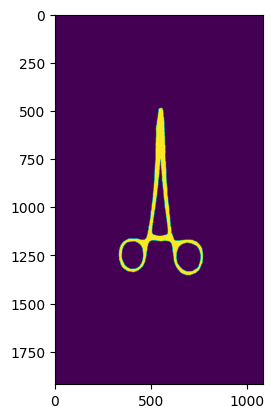

In [ ]:
plt.imshow(mask_for_cotracker)




# Auto annotate (scissors)

In [ ]:
from ultralytics import ASSETS, SAM, YOLO, FastSAM
sam_model = SAM("sam2.1_l.pt")
yolo_model = YOLO("yolo11x-seg.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 428M/428M [00:13<00:00, 33.6MB/s]


100%|██████████| 119M/119M [00:03<00:00, 37.4MB/s]


In [ ]:
!pip install torchinfo
from torchinfo import summary

# Display a summary of the model
summary(yolo_model.model, input_size=(1, 3, 640, 640))  # Adjust input size for your model

In [ ]:
# get working directory
import os
os.getcwd()

'/content'

In [ ]:
# zip video frame folder
!zip -r /content/video_frames.zip /content/video_frames

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
!mkdir -p /content/video_frames
# stop up to 700 frames
!ffmpeg -i "/content/drive/MyDrive/Humanitas/surgical_training/Testing/IMG_1025.mp4" -q:v 2 -vframes 500 /content/video_frames/%05d.jpeg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

resize img (yolo need square inputs)

In [ ]:
import cv2
import os
from pathlib import Path

# Input and output folders
input_folder = "/content/video_frames"
output_folder = "/content/resized_images"
os.makedirs(output_folder, exist_ok=True)

# Target size
target_size = 640

def resize_and_pad(image, target_size):
    h, w, _ = image.shape
    # Compute scale to fit the shorter side to target size
    scale = target_size / max(h, w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize image while keeping aspect ratio
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create a blank square canvas (black background)
    canvas = cv2.copyMakeBorder(
        resized,
        top=(target_size - new_h) // 2,
        bottom=(target_size - new_h + 1) // 2,
        left=(target_size - new_w) // 2,
        right=(target_size - new_w + 1) // 2,
        borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0),  # Black padding
    )

    return canvas

# Process all images in the input folder
for image_file in Path(input_folder).glob("*.jpeg"):
    image = cv2.imread(str(image_file))
    resized_image = resize_and_pad(image, target_size)
    output_path = os.path.join(output_folder, image_file.name)
    cv2.imwrite(output_path, resized_image)

print(f"Resized images saved to {output_folder}")


Resized images saved to /content/resized_images


In [ ]:
# delete resize auto annotate folder
import shutil
shutil.rmtree('/content/segment-anything-2/resized_images')

In [ ]:
# import
from ultralytics import SAM, YOLO

sam_model = SAM("sam2.1_l.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 428M/428M [00:08<00:00, 50.1MB/s]


In [ ]:
#results = sam_model("/content/resized_images", points=[[[511, 392], [428, 355], [562, 414],[448, 354]]], labels=[[1, 1, 1, 1]])


image 1/965 /content/resized_images/00036.jpeg: 1024x1024 1 0, 681.5ms
image 2/965 /content/resized_images/00037.jpeg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 15876.7ms
image 3/965 /content/resized_images/00038.jpeg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 14212.8ms


KeyboardInterrupt: 

In [ ]:
results[0].masks.data.cpu().numpy().shape

(1, 640, 640)

In [ ]:
sam_model?

In [ ]:
Clicked at: (511, 392)
Clicked at: (428, 355)
Clicked at: (562, 414)
Clicked at: (448, 354)

In [ ]:
result = results[0]
mask_data = result.masks.data.cpu().numpy()

In [ ]:
import os

# Path to the folder containing the images
folder_path = "/content/resized_images"  # Replace with your folder path

# Get all JPEG images sorted by name
images = sorted([img for img in os.listdir(folder_path) if img.endswith(".jpeg")])

# Define how many images to delete
num_to_delete = 35

# Loop through the first `num_to_delete` images and delete them
for img in images[:num_to_delete]:
    file_path = os.path.join(folder_path, img)
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")


Deleted: /content/resized_images/00001.jpeg
Deleted: /content/resized_images/00002.jpeg
Deleted: /content/resized_images/00003.jpeg
Deleted: /content/resized_images/00004.jpeg
Deleted: /content/resized_images/00005.jpeg
Deleted: /content/resized_images/00006.jpeg
Deleted: /content/resized_images/00007.jpeg
Deleted: /content/resized_images/00008.jpeg
Deleted: /content/resized_images/00009.jpeg
Deleted: /content/resized_images/00010.jpeg
Deleted: /content/resized_images/00011.jpeg
Deleted: /content/resized_images/00012.jpeg
Deleted: /content/resized_images/00013.jpeg
Deleted: /content/resized_images/00014.jpeg
Deleted: /content/resized_images/00015.jpeg
Deleted: /content/resized_images/00016.jpeg
Deleted: /content/resized_images/00017.jpeg
Deleted: /content/resized_images/00018.jpeg
Deleted: /content/resized_images/00019.jpeg
Deleted: /content/resized_images/00020.jpeg
Deleted: /content/resized_images/00021.jpeg
Deleted: /content/resized_images/00022.jpeg
Deleted: /content/resized_images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Loop through each result in the array
for i, result in enumerate(results[]):
    result = result[0]
    # Extract the original image
    orig_img = result.orig_img  # Original image as a NumPy array

    # Extract mask data
    mask_data = result.masks.data.cpu().numpy()  # Convert mask tensor to NumPy array

    # Loop through each mask in the current result (in case there are multiple masks)
    for j, mask in enumerate(mask_data):
        # Convert mask to uint8 for compatibility
        mask_uint8 = (mask > 0).astype(np.uint8)  # Convert to binary and uint8

        # Resize the mask to match the original image dimensions
        mask_resized = cv2.resize(mask_uint8, (orig_img.shape[1], orig_img.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Create a colored overlay for the mask
        colored_mask = np.zeros_like(orig_img, dtype=np.uint8)
        colored_mask[:, :, 0] = mask_resized * 255  # Apply mask to the red channel

        # Overlay the mask onto the original image
        overlayed_image = cv2.addWeighted(orig_img, 0.8, colored_mask, 0.5, 0)

        # Plot the overlayed image
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Result {i+1}, Mask {j+1}")
        plt.show()


IndexError: index 3 is out of bounds for dimension 0 with size 1

try

In [ ]:
# plot result
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


In [ ]:
from ultralytics.data.annotator import auto_annotate

auto_annotate(data="/content/resized_images", det_model= "yolo11x-seg.pt" , sam_model="sam2.1_l.pt", classes= 76)


image 1/500 /content/resized_images/00001.jpeg: 640x640 (no detections), 101.0ms
image 2/500 /content/resized_images/00002.jpeg: 640x640 (no detections), 82.9ms
image 3/500 /content/resized_images/00003.jpeg: 640x640 (no detections), 77.0ms
image 4/500 /content/resized_images/00004.jpeg: 640x640 (no detections), 69.9ms
image 5/500 /content/resized_images/00005.jpeg: 640x640 (no detections), 69.4ms
image 6/500 /content/resized_images/00006.jpeg: 640x640 (no detections), 68.8ms
image 7/500 /content/resized_images/00007.jpeg: 640x640 (no detections), 70.5ms
image 8/500 /content/resized_images/00008.jpeg: 640x640 (no detections), 70.3ms
image 9/500 /content/resized_images/00009.jpeg: 640x640 (no detections), 69.1ms
image 10/500 /content/resized_images/00010.jpeg: 640x640 (no detections), 67.8ms
image 11/500 /content/resized_images/00011.jpeg: 640x640 (no detections), 70.4ms
image 12/500 /content/resized_images/00012.jpeg: 640x640 (no detections), 70.3ms
image 13/500 /content/resized_image

In [ ]:
import os

# Directory containing the .txt files
input_folder = "/content/resized_images_auto_annotate_labels"  # Replace with your folder path
output_folder = "/content/Scissors"  # Replace with your desired output folder
target_class_id = "76"  # The class ID to filter for
new_class_id = "1"  # The new class ID to replace with

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate through all files in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith(".txt"):  # Process only .txt files
        input_file_path = os.path.join(input_folder, file_name)
        output_file_path = os.path.join(output_folder, file_name)

        updated_lines = []  # Store all matching lines for the target class

        # Read and process the file
        with open(input_file_path, "r") as infile:
            for line in infile:
                parts = line.split()  # Split the line into components
                if parts[0] == target_class_id:
                    parts[0] = new_class_id  # Replace the class ID
                    updated_lines.append(" ".join(parts) + "\n")  # Add to the list of updated lines

        # Write the updated lines to the output file, if any matches found
        if updated_lines:
            with open(output_file_path, "w") as outfile:
                outfile.writelines(updated_lines)
            print(f"Saved file with matching occurrences: {file_name}")
        else:
            print(f"No matches found in {file_name}, skipping.")

print(f"Processed files saved in {output_folder}")


Saved file with matching occurrences: 00474.txt
Saved file with matching occurrences: 00229.txt
Saved file with matching occurrences: 00111.txt
Saved file with matching occurrences: 00074.txt
Saved file with matching occurrences: 00109.txt
Saved file with matching occurrences: 00478.txt
Saved file with matching occurrences: 00034.txt
Saved file with matching occurrences: 00467.txt
Saved file with matching occurrences: 00079.txt
Saved file with matching occurrences: 00174.txt
Saved file with matching occurrences: 00302.txt
Saved file with matching occurrences: 00432.txt
Saved file with matching occurrences: 00346.txt
Saved file with matching occurrences: 00289.txt
Saved file with matching occurrences: 00320.txt
Saved file with matching occurrences: 00500.txt
Saved file with matching occurrences: 00301.txt
Saved file with matching occurrences: 00420.txt
Saved file with matching occurrences: 00037.txt
Saved file with matching occurrences: 00076.txt
Saved file with matching occurrences: 00

In [ ]:
import gc
import torch

# Delete variables
del preidcotr  # Replace with your variable names
gc.collect()

# Free GPU memory
torch.cuda.empty_cache()


NameError: name 'variable_name' is not defined

In [ ]:
# dowload folder annotated images
!zip -r /content/annotated_frames_images.zip /content/images_annotated
# dowload folder annotated scissors
!zip -r /content/annotated_frames_scissors.zip /content/Scissors

  adding: content/images_annotated/ (stored 0%)
  adding: content/images_annotated/0452.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0280.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0285.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0315.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0313.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0308.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0479.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0461.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0362.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0335.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0356.jpeg_segmentation.png (deflated 1%)
  adding: content/images_annotated/0739.jpeg_segmentation.png (deflated 2%)
  adding: content/images_annotated/0341.

In [ ]:
# delete scissors directoryt
import shutil
shutil.rmtree('/content/Scissors')
shutil.rmtree('/content/Scissors_bbox')
shutil.rmtree('/content/to')

FileNotFoundError: [Errno 2] No such file or directory: '/content/to'

Create bbox

In [ ]:
import os
import numpy as np

def load_polygon(file_path):
    """
    Load polygon coordinates from a text file.
    """
    with open(file_path, 'r') as file:
        data = file.read().strip()
        # Split the data into a list of numbers
        values = data.split()
        class_label = values[0]  # Extract the class label
        coordinates = list(map(float, values[1:]))  # Rest are coordinates
        num_coords = len(values[1:])

        return class_label, np.array(coordinates).reshape(-1, 2)  # Reshape into (N, 2)

def polygon_to_bbox_yolo(polygon, image_width, image_height):
    """
    Compute bounding box from polygon coordinates and normalize for YOLO format.
    Returns (x_center, y_center, width, height).
    """
    x_coords = polygon[:, 0]
    y_coords = polygon[:, 1]
    x_min = x_coords.min()
    x_max = x_coords.max()
    y_min = y_coords.min()
    y_max = y_coords.max()

    # Compute bounding box dimensions
    width = x_max - x_min
    height = y_max - y_min
    x_center = x_min + width / 2
    y_center = y_min + height / 2

    # Normalize to image dimensions
    x_center /= image_width
    y_center /= image_height
    width /= image_width
    height /= image_height

    return x_center, y_center, width, height

def process_folder(input_folder, output_folder, image_width, image_height):
    """
    Process all .txt files in the input folder to extract YOLO-compatible bounding boxes
    and save the results in the output folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # Create output folder if it doesn't exist

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.txt'):  # Process only .txt files
            input_path = os.path.join(input_folder, file_name)
            output_path = os.path.join(output_folder, file_name)

            # Load polygon and compute bounding box
            class_label, polygon = load_polygon(input_path)
            x_center, y_center, width, height = polygon_to_bbox_yolo(polygon, image_width, image_height)

            # Write YOLO-compatible bounding box to output file
            with open(output_path, 'w') as output_file:
                output_file.write(f"{class_label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

            print(f"Processed {file_name} -> {output_path}")

# Example usage
input_folder = "/content/Scissors"  # Replace with your input folder path
output_folder = "/content/Scissors_bbox"  # Replace with your output folder path
image_width = 1  # Replace with your image width
image_height = 1  # Replace with your image height

process_folder(input_folder, output_folder, image_width, image_height)


Processed 0053.txt -> /content/pinza_bbox/0053.txt
Processed 0640.txt -> /content/pinza_bbox/0640.txt
Processed 0480.txt -> /content/pinza_bbox/0480.txt
Processed 0509.txt -> /content/pinza_bbox/0509.txt
Processed 0106.txt -> /content/pinza_bbox/0106.txt
Processed 0043.txt -> /content/pinza_bbox/0043.txt
Processed 0545.txt -> /content/pinza_bbox/0545.txt
Processed 0301.txt -> /content/pinza_bbox/0301.txt
Processed 0563.txt -> /content/pinza_bbox/0563.txt
Processed 0521.txt -> /content/pinza_bbox/0521.txt
Processed 0594.txt -> /content/pinza_bbox/0594.txt
Processed 0343.txt -> /content/pinza_bbox/0343.txt
Processed 0581.txt -> /content/pinza_bbox/0581.txt
Processed 0610.txt -> /content/pinza_bbox/0610.txt
Processed 0428.txt -> /content/pinza_bbox/0428.txt
Processed 0452.txt -> /content/pinza_bbox/0452.txt
Processed 0114.txt -> /content/pinza_bbox/0114.txt
Processed 0544.txt -> /content/pinza_bbox/0544.txt
Processed 0519.txt -> /content/pinza_bbox/0519.txt
Processed 0582.txt -> /content/

Visualize

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_polygon(file_path):
    """
    Load polygon coordinates from a text file.
    """
    with open(file_path, 'r') as file:
        data = file.read().strip()
        values = list(map(float, data.split()[1:]))  # Skip class label
        return np.array(values).reshape(-1, 2)  # Reshape into (N, 2)

def load_bbox(file_path, image_width, image_height):
    """
    Load YOLO-format bounding box from a text file and denormalize.
    """
    with open(file_path, 'r') as file:
        line = file.readline().strip()
        _, x_center, y_center, width, height = map(float, line.split())

        # Denormalize bounding box
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height

        # Convert to (x_min, y_min, x_max, y_max)
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        return x_min, y_min, x_max, y_max

def plot_frame_with_annotations(frame_path, polygon, bbox, output_path):
    """
    Plot the frame with polygon and bounding box annotations.
    """
    # Open the frame image
    frame = Image.open(frame_path)
    image_width, image_height = frame.size

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(frame)
    plt.axis('off')

    # Plot the polygon
    if polygon is not None:
        plt.plot(
            np.append(polygon[:, 0] * image_width, polygon[0, 0] * image_width),
            np.append(polygon[:, 1] * image_height, polygon[0, 1] * image_height),
            color='blue', linewidth=2, label='Polygon'
        )

    # Plot the bounding box
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        plt.plot(
            [x_min, x_max, x_max, x_min, x_min],
            [y_min, y_min, y_max, y_max, y_min],
            color='red', linewidth=2, linestyle='--', label='Bounding Box'
        )

    plt.legend()
    plt.savefig(output_path)
    plt.close()

def visualize_annotations(polygon_folder, bbox_folder, frames_folder, output_folder):
    """
    Visualize polygons and bounding boxes on frames.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(frames_folder):
        if file_name.endswith(('.jpg', '.png', '.jpeg')):
            base_name = os.path.splitext(file_name)[0]
            frame_path = os.path.join(frames_folder, file_name)
            polygon_path = os.path.join(polygon_folder, base_name + '.txt')
            bbox_path = os.path.join(bbox_folder, base_name + '.txt')
            output_path = os.path.join(output_folder, base_name + '_annotated.png')

            # Ensure corresponding files exist
            if not os.path.exists(polygon_path) or not os.path.exists(bbox_path):
                print(f"Missing annotations for {file_name}. Skipping...")
                continue

            # Load polygon, bounding box, and frame
            frame = Image.open(frame_path)
            image_width, image_height = frame.size
            polygon = load_polygon(polygon_path)
            bbox = load_bbox(bbox_path, image_width, image_height)

            # Plot and save the annotated frame
            plot_frame_with_annotations(frame_path, polygon, bbox, output_path)
            print(f"Annotated {file_name} -> {output_path}")



polygon_folder = "/content/Scissors"  # Replace with your polygon folder path
bbox_folder = "/content/Scissors_bbox"        # Replace with your bbox folder path
frames_folder = "/content/resized_images"   # Replace with your frames folder path
output_folder = "/content/annotated_frames"    # Replace with your output folder path

visualize_annotations(polygon_folder, bbox_folder, frames_folder, output_folder)


Missing annotations for 0695.jpeg. Skipping...
Missing annotations for 0180.jpeg. Skipping...
Missing annotations for 0216.jpeg. Skipping...
Missing annotations for 0207.jpeg. Skipping...
Missing annotations for 0220.jpeg. Skipping...
Missing annotations for 0083.jpeg. Skipping...
Missing annotations for 0287.jpeg. Skipping...
Annotated 0109.jpeg -> /content/annotated_frames/0109_annotated.png
Missing annotations for 0232.jpeg. Skipping...
Annotated 0608.jpeg -> /content/annotated_frames/0608_annotated.png
Annotated 0456.jpeg -> /content/annotated_frames/0456_annotated.png
Missing annotations for 0495.jpeg. Skipping...
Missing annotations for 0151.jpeg. Skipping...
Annotated 0520.jpeg -> /content/annotated_frames/0520_annotated.png
Missing annotations for 0674.jpeg. Skipping...
Missing annotations for 0291.jpeg. Skipping...
Missing annotations for 0556.jpeg. Skipping...
Missing annotations for 0689.jpeg. Skipping...
Missing annotations for 0185.jpeg. Skipping...
Missing annotations for

# Sam for pinze

## Extract frame and resize

In [ ]:
# DELETE DIRECTORY
import shutil
shutil.rmtree('/content/video_frames')

In [ ]:
!mkdir -p /content/video_frames
# stop up to 700 frames
!ffmpeg -i "/content/drive/MyDrive/Humanitas/surgical_training/Testing/IMG_1025.mp4" -q:v 2  /content/video_frames/%05d.jpeg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
import cv2
import os
from pathlib import Path

# Input and output folders
input_folder = "/content/video_frames"
output_folder = "/content/resized_images"
os.makedirs(output_folder, exist_ok=True)

# Target size
target_size = 640

def resize_and_pad(image, target_size):
    h, w, _ = image.shape
    # Compute scale to fit the shorter side to target size
    scale = target_size / max(h, w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize image while keeping aspect ratio
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create a blank square canvas (black background)
    canvas = cv2.copyMakeBorder(
        resized,
        top=(target_size - new_h) // 2,
        bottom=(target_size - new_h + 1) // 2,
        left=(target_size - new_w) // 2,
        right=(target_size - new_w + 1) // 2,
        borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0),  # Black padding
    )

    return canvas

# Process all images in the input folder
for image_file in Path(input_folder).glob("*.jpeg"):
    image = cv2.imread(str(image_file))
    resized_image = resize_and_pad(image, target_size)
    output_path = os.path.join(output_folder, image_file.name)
    cv2.imwrite(output_path, resized_image)

print(f"Resized images saved to {output_folder}")


Resized images saved to /content/resized_images


## Import sam2 to annotate

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q


HOME: /content
Cloning into 'segment-anything-2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 974 (delta 17), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (974/974), 128.94 MiB | 34.17 MiB/s, done.
Resolving deltas: 100% (334/334), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.8 MB/s eta

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True


using device: cuda


In [ ]:
import torch
from sam2.build_sam import build_sam2_video_predictor

# Load the SAM 2 model and predictor
model_cfg = "/configs/sam2/sam2_hiera_b+.yaml"
checkpoint = "/content/checkpoints/sam2_hiera_base_plus.pt"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)


/content/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [ ]:
def initialize_sam(predictor,SOURCE_FRAMES):
  """Initialize the SAM predictor."""

  inference_state = predictor.init_state(video_path=SOURCE_FRAMES)
  return inference_state

In [ ]:
predictor.reset_state(inference_state)

In [ ]:
# delete resized images
import shutil
shutil.rmtree('/content/output_segmented_pinze')

Transfer 500 resized frames to a working folder to be processed

In [ ]:
# get starting mask or points
# unzip dataset
!unzip /content/dataset_forceps.zip -d /content/dataset



In [ ]:
# delete folder
import shutil
shutil.rmtree('/content/annotated_frames')

In [6]:
import os
import shutil
start_frame = 499
end_frame = 1000
os.makedirs("videos/input_resized_forceps", exist_ok=True)
#copy changing name
j = 0
for i in range(start_frame, end_frame):
  shutil.copy(f"videos/IMG_1025_frames_resized/{i:05d}.jpeg", f"videos/input_resized_forceps/{j:05d}.jpeg")
  j += 1


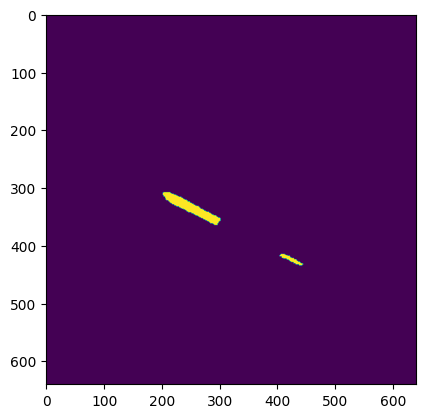

In [ ]:
# check if start frame in dataset, if yes from polygon coord take mask
import os
if os.path.exists(f"/content/dataset/labels/train/{start_frame:05d}.txt"):
  polygon_path = f"/content/dataset/labels/train/{start_frame:05d}.txt"
elif os.path.exists(f"/content/dataset/labels/val/{start_frame:05d}.txt"):
  polygon_path = f"/content/dataset/labels/val/{start_frame:05d}.txt"

# from polygon path extract mask, remove first element that is the label

polygons = []
with open(polygon_path, 'r') as file:
    for line in file:
      line = line[1:]
      values = list(map(float, line.split()))  # Load all coordinates
      polygon = np.array(values).reshape(-1, 2)  # Reshape into (N, 2)
      polygons.append(polygon)

# from polygons get masks

mask_height, mask_width = 640,640

forceps_mask = np.zeros((mask_height, mask_width), dtype=np.uint8)

for polygon in polygons:
  polygon_array = np.array(polygon * [mask_width,mask_height], dtype=np.int32)
  cv2.fillPoly(forceps_mask, [polygon_array], 255)


plt.imshow(forceps_mask)
plt.show()


## Get polygons coordintaes from sam2 masks

In [ ]:
import cv2
import os
import torch
import numpy as np

def segment_sam(jpeg_folder_path, inference_state, labels, start_frame, points_array = None, mask = None):
    # Create save folder for polygons
    output_polygon_folder = "/content/output_segmented_pinze"
    os.makedirs(output_polygon_folder, exist_ok=True)

    # Add the mask to the first frame
    with torch.inference_mode():
      if points_array:
        predictor.add_new_points_or_box(inference_state, frame_idx=start_frame, obj_id=0, points=points_array, labels=labels)
      elif mask is not None:
        predictor.add_new_mask(inference_state, frame_idx=start_frame, obj_id=0, mask=mask)
      else:
        raise ValueError("Either points_array or mask must be provided.")

    # Propagate the mask through the rest of the frames
    for frame_idx, obj_ids, masks in predictor.propagate_in_video(inference_state, start_frame_idx=start_frame):
        frame_path = os.path.join(jpeg_folder_path, f"{frame_idx:05d}.jpeg")
        frame = cv2.imread(frame_path)

        if frame is None:
            print(f"Error loading frame {frame_idx}")
            continue

        with torch.no_grad():
            mask_np = masks[0].cpu().numpy()  # Convert the mask to a NumPy array

        # Remove the extra dimension and create a binary mask
        mask_np = np.squeeze(mask_np)
        _, binary_mask = cv2.threshold(mask_np, 0.5, 1, cv2.THRESH_BINARY)
        binary_mask = (binary_mask * 255).astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Normalize contours
        img_height, img_width = frame.shape[:2]
        normalized_contours = [
            [(x / img_width, y / img_height) for x, y in contour.reshape(-1, 2)]
            for contour in contours
        ]

        # Save normalized contours to a .txt file
        output_txt_path = os.path.join(output_polygon_folder, f"{frame_idx:05d}.txt")
        with open(output_txt_path, 'w') as f:
            for contour in normalized_contours:
                line = " ".join(f"{x:.6f} {y:.6f}" for x, y in contour)
                f.write(line + "\n")

        print(f"Saved polygons for frame {frame_idx} to {output_txt_path}")


# Example usage
 = np.array([[511, 392], [428, 355], [562, 414], [448, 354]], dtype=np.float32)
labels = np.array([1, 1, 1, 1], np.int32)  # `1` means positive click
jpeg_folder = "/content/input_resized_forceps"

# Initialize the SAM inference state
inference_state = initialize_sam(predictor, jpeg_folder)

# Run the segmentation and save polygons
segment_sam(jpeg_folder, inference_state, labels=labels, start_frame = 0, mask = forceps_mask)


In [ ]:
# clean cuda memory
torch.cuda.empty_cache()

## **visualize**

[INFO] Annotated 00309.jpeg -> /content/annotated_frames/00309_annotated.png
[INFO] Annotated 00391.jpeg -> /content/annotated_frames/00391_annotated.png
[INFO] Annotated 00371.jpeg -> /content/annotated_frames/00371_annotated.png
[INFO] Annotated 00234.jpeg -> /content/annotated_frames/00234_annotated.png
[INFO] Annotated 00112.jpeg -> /content/annotated_frames/00112_annotated.png
[INFO] Annotated 00154.jpeg -> /content/annotated_frames/00154_annotated.png
[INFO] Annotated 00343.jpeg -> /content/annotated_frames/00343_annotated.png
[INFO] Annotated 00109.jpeg -> /content/annotated_frames/00109_annotated.png
[INFO] Annotated 00424.jpeg -> /content/annotated_frames/00424_annotated.png
[INFO] Annotated 00058.jpeg -> /content/annotated_frames/00058_annotated.png
[INFO] Annotated 00327.jpeg -> /content/annotated_frames/00327_annotated.png
[INFO] Annotated 00389.jpeg -> /content/annotated_frames/00389_annotated.png
[INFO] Annotated 00015.jpeg -> /content/annotated_frames/00015_annotated.png

KeyboardInterrupt: 

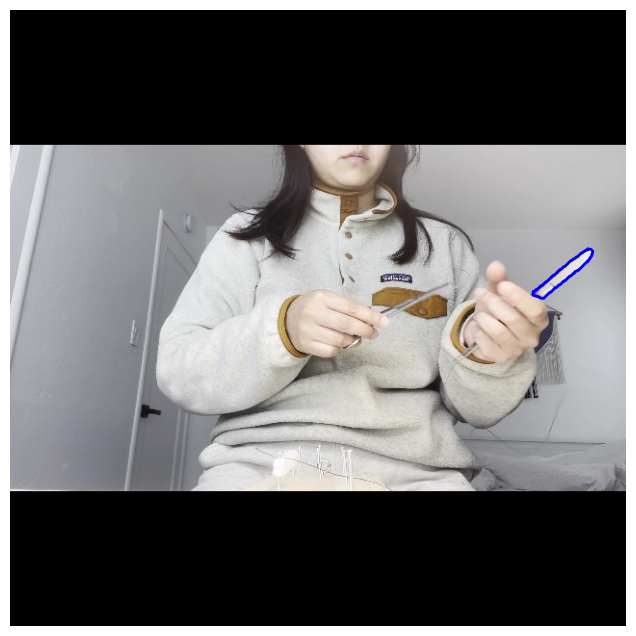

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_polygon(file_path):
    """
    Load polygon coordinates from a text file.
    Each line represents a polygon, with coordinates normalized (0 to 1).
    """
    polygons = []
    with open(file_path, 'r') as file:
        for line in file:
            values = list(map(float, line.split()))  # Load all coordinates
            polygon = np.array(values).reshape(-1, 2)  # Reshape into (N, 2)
            polygons.append(polygon)
    return polygons

def plot_frame_with_polygons(frame_path, polygons, output_path):
    """
    Plot the image with overlaid polygons and save the output.
    """
    # Open the image
    frame = Image.open(frame_path)
    image_width, image_height = frame.size

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(frame)
    plt.axis('off')

    # Overlay each polygon
    for polygon in polygons:
        plt.plot(
            np.append(polygon[:, 0] * image_width, polygon[0, 0] * image_width),  # Loop to the start
            np.append(polygon[:, 1] * image_height, polygon[0, 1] * image_height),
            color='blue', linewidth=2
        )

    # Save the annotated frame
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def visualize_polygons(polygon_folder, frames_folder, output_folder):
    """
    Visualize polygons on all frames in the given folders.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(frames_folder):
        if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            base_name = os.path.splitext(file_name)[0]
            frame_path = os.path.join(frames_folder, file_name)
            polygon_path = os.path.join(polygon_folder, base_name + '.txt')
            output_path = os.path.join(output_folder, base_name + '_annotated.png')

            # Ensure the polygon file exists
            if not os.path.exists(polygon_path):
                print(f"[WARNING] Missing polygon annotations for {file_name}. Skipping...")
                continue

            try:
                # Load polygons and process the frame
                polygons = load_polygon(polygon_path)
                if polygons == []:
                  continue
                plot_frame_with_polygons(frame_path, polygons, output_path)
                print(f"[INFO] Annotated {file_name} -> {output_path}")
            except Exception as e:
                print(f"[ERROR] Failed to process {file_name}: {e}")

# Example usage
polygon_folder = "/root/surgical_training/output_segmented_pinze"  # Path to polygon files
frames_folder = "/root/surgical_training/videos/input_resized_forceps"   # Path to image files
output_folder = "annotated_frames"       # Path to save annotated images

visualize_polygons(polygon_folder, frames_folder, output_folder)


In [ ]:
plt.show()

In [ ]:
# delete folder

import shutil
shutil.rmtree('/content/output_segmented_forceps_batch')

In [ ]:
import os

def clean_and_modify_polygons(polygon_folder):
    """
    Clean and modify polygon .txt files in a folder:
    1. Keep all lines in each file.
    2. Add a '0' label at the beginning of each line.
    3. Keep empty files intact.

    Parameters:
        polygon_folder: Path to the folder containing the polygon .txt files.
    """

    for file_name in os.listdir(polygon_folder):
        if file_name.endswith('.txt'):
            file_path = os.path.join(polygon_folder, file_name)

            # Read the contents of the file
            with open(file_path, 'r') as file:
                lines = file.readlines()

            # Modify lines by adding '0 ' at the beginning of each line
            modified_lines = [f"0 {line.strip()}\n" for line in lines]

            # Ensure empty files remain intact
            if not modified_lines:
                print(f"Empty file: {file_name} remains unchanged.")
                continue

            # Overwrite the file with the modified content
            with open(file_path, 'w') as file:
                file.writelines(modified_lines)

            print(f"Processed: {file_name}")

# Example usage
polygon_folder = "/content/output_segmented_pinze"  # Replace with your polygon folder path
clean_and_modify_polygons(polygon_folder)


Processed: 00120.txt
Processed: 00310.txt
Processed: 00197.txt
Processed: 00165.txt
Processed: 00409.txt
Processed: 00309.txt
Processed: 00474.txt
Processed: 00428.txt
Processed: 00099.txt
Processed: 00239.txt
Processed: 00388.txt
Processed: 00411.txt
Processed: 00018.txt
Processed: 00331.txt
Processed: 00043.txt
Processed: 00375.txt
Processed: 00466.txt
Processed: 00143.txt
Processed: 00173.txt
Processed: 00136.txt
Processed: 00086.txt
Processed: 00359.txt
Processed: 00291.txt
Processed: 00288.txt
Processed: 00127.txt
Processed: 00345.txt
Processed: 00077.txt
Processed: 00346.txt
Processed: 00186.txt
Processed: 00475.txt
Processed: 00206.txt
Processed: 00039.txt
Processed: 00408.txt
Processed: 00202.txt
Processed: 00423.txt
Processed: 00399.txt
Processed: 00281.txt
Processed: 00276.txt
Processed: 00273.txt
Processed: 00122.txt
Processed: 00495.txt
Processed: 00492.txt
Processed: 00358.txt
Processed: 00145.txt
Processed: 00047.txt
Processed: 00215.txt
Processed: 00339.txt
Processed: 00

In [ ]:
import shutil
shift = 499
os.makedirs("/content/output_segmented_forceps_batch", exist_ok=True)
os.makedirs("/content/image_segmented_forceps_batch", exist_ok=True)
#copy changing name
j = 499
for i in range(500):
  shutil.copy(f"/content/output_segmented_pinze/{i:05d}.txt", f"/content/output_segmented_forceps_batch/{i+j:05d}.txt")
  shutil.copy(f"/content/input_resized_forceps/{i:05d}.jpeg", f"/content/image_segmented_forceps_batch/{i+j:05d}.jpeg")
  j += 1



# Construct the dataset

In [ ]:
# zip and dowload annotated images
!zip -r /content/annotated_frames.zip /content/annotated_frames

  adding: content/annotated_frames/ (stored 0%)
  adding: content/annotated_frames/00263_annotated.png (deflated 1%)
  adding: content/annotated_frames/00089_annotated.png (deflated 1%)
  adding: content/annotated_frames/00473_annotated.png (deflated 1%)
  adding: content/annotated_frames/00405_annotated.png (deflated 1%)
  adding: content/annotated_frames/00379_annotated.png (deflated 1%)
  adding: content/annotated_frames/00289_annotated.png (deflated 1%)
  adding: content/annotated_frames/00051_annotated.png (deflated 1%)
  adding: content/annotated_frames/00471_annotated.png (deflated 1%)
  adding: content/annotated_frames/00276_annotated.png (deflated 1%)
  adding: content/annotated_frames/00222_annotated.png (deflated 1%)
  adding: content/annotated_frames/00084_annotated.png (deflated 1%)
  adding: content/annotated_frames/00395_annotated.png (deflated 1%)
  adding: content/annotated_frames/00336_annotated.png (deflated 1%)
  adding: content/annotated_frames/00306_annotated.png 

## Merge scissors annotation and forceps

In [ ]:
import os

# Directories containing the .txt files for scissors and pinze
scissors_folder = "/content/Scissors"  # Folder containing scissors (1) annotations
pinze_folder = "/content/output_segmented_pinze"       # Folder containing pinze (0) annotations
output_folder = "/content/MergedLabels"  # Folder to save the merged .txt files

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get all unique frame names (common between scissors and pinze folders)
scissors_files = set(os.listdir(scissors_folder))
pinze_files = set(os.listdir(pinze_folder))
all_files = scissors_files.union(pinze_files)

# Iterate through all frame names
for file_name in all_files:
    output_file_path = os.path.join(output_folder, file_name)
    merged_lines = []  # Store all annotations for the frame

    # Read scissors annotations (if present)
    scissors_path = os.path.join(scissors_folder, file_name)
    if os.path.exists(scissors_path):
        with open(scissors_path, "r") as scissors_file:
            merged_lines.extend(scissors_file.readlines())

    # Read pinze annotations (if present)
    pinze_path = os.path.join(pinze_folder, file_name)
    if os.path.exists(pinze_path):
        with open(pinze_path, "r") as pinze_file:
            merged_lines.extend(pinze_file.readlines())

    # Write merged annotations to the output file
    if merged_lines:
        with open(output_file_path, "w") as outfile:
            outfile.writelines(merged_lines)
        print(f"Merged labels saved for: {file_name}")
    else:
        print(f"No annotations found for: {file_name}")

print(f"Merged files saved in {output_folder}")


Merged labels saved for: 00295.txt
Merged labels saved for: 00326.txt
Merged labels saved for: 00104.txt
Merged labels saved for: 00402.txt
Merged labels saved for: 00395.txt
Merged labels saved for: 00255.txt
Merged labels saved for: 00413.txt
Merged labels saved for: 00208.txt
Merged labels saved for: 00307.txt
Merged labels saved for: 00222.txt
Merged labels saved for: 00291.txt
Merged labels saved for: 00458.txt
Merged labels saved for: 00196.txt
Merged labels saved for: 00119.txt
Merged labels saved for: 00476.txt
Merged labels saved for: 00265.txt
Merged labels saved for: 00386.txt
Merged labels saved for: 00411.txt
Merged labels saved for: 00389.txt
Merged labels saved for: 00309.txt
No annotations found for: 00162.txt
Merged labels saved for: 00027.txt
Merged labels saved for: 00288.txt
Merged labels saved for: 00135.txt
Merged labels saved for: 00045.txt
Merged labels saved for: 00332.txt
Merged labels saved for: 00446.txt
Merged labels saved for: 00146.txt
Merged labels saved

In [ ]:
import os
import shutil
import numpy as np

def create_yolo_dataset(images_folder, labels_folder, output_folder, split_ratio=0.8):
    """
    Create a YOLO dataset by pairing images with their corresponding labels
    and organizing them into train/val subsets.

    Args:
        images_folder (str): Path to the folder containing the images.
        labels_folder (str): Path to the folder containing the merged labels.
        output_folder (str): Path to the output dataset folder.
        split_ratio (float): Ratio of data to use for training (default is 80% train, 20% val).
    """
    # Define output paths
    train_images_folder = os.path.join(output_folder, "images", "train")
    val_images_folder = os.path.join(output_folder, "images", "val")
    train_labels_folder = os.path.join(output_folder, "labels", "train")
    val_labels_folder = os.path.join(output_folder, "labels", "val")

    # Create the directory structure
    for folder in [train_images_folder, val_images_folder, train_labels_folder, val_labels_folder]:
        os.makedirs(folder, exist_ok=True)

    # Process each image
    for image_file in os.listdir(images_folder):
        if image_file.endswith(('.jpg', '.png', '.jpeg')):
            base_name = os.path.splitext(image_file)[0]
            image_path = os.path.join(images_folder, image_file)
            label_path = os.path.join(labels_folder, base_name + ".txt")

            # Check if corresponding label exists
            if not os.path.exists(label_path):
                print(f"Missing label for image: {image_file}. Skipping...")
                continue

            # Decide whether to assign to train or val
            subset = "train" if np.random.rand() < split_ratio else "val"

            # Copy image and label to the appropriate subset folder
            image_output_path = os.path.join(output_folder, "images", subset, image_file)
            label_output_path = os.path.join(output_folder, "labels", subset, base_name + ".txt")

            shutil.copy(image_path, image_output_path)
            shutil.copy(label_path, label_output_path)

            print(f"Paired {image_file} -> {label_output_path}")

# Example usage
images_folder = "/content/image_segmented_forceps_batch"       # Path to images folder
labels_folder = "/content/output_segmented_forceps_batch"         # Path to merged labels folder
output_folder = "/content/dataset_2"              # Path to the output dataset folder

create_yolo_dataset(images_folder, labels_folder, output_folder)


Paired 00913.jpeg -> /content/dataset_2/labels/val/00913.txt
Paired 00761.jpeg -> /content/dataset_2/labels/val/00761.txt
Paired 01169.jpeg -> /content/dataset_2/labels/val/01169.txt
Paired 01347.jpeg -> /content/dataset_2/labels/val/01347.txt
Paired 01329.jpeg -> /content/dataset_2/labels/train/01329.txt
Paired 00785.jpeg -> /content/dataset_2/labels/train/00785.txt
Paired 01145.jpeg -> /content/dataset_2/labels/train/01145.txt
Paired 01035.jpeg -> /content/dataset_2/labels/train/01035.txt
Paired 00987.jpeg -> /content/dataset_2/labels/train/00987.txt
Paired 00607.jpeg -> /content/dataset_2/labels/train/00607.txt
Paired 01113.jpeg -> /content/dataset_2/labels/train/01113.txt
Paired 01091.jpeg -> /content/dataset_2/labels/train/01091.txt
Paired 01289.jpeg -> /content/dataset_2/labels/train/01289.txt
Paired 01385.jpeg -> /content/dataset_2/labels/val/01385.txt
Paired 00847.jpeg -> /content/dataset_2/labels/train/00847.txt
Paired 01375.jpeg -> /content/dataset_2/labels/train/01375.txt
Pa

In [ ]:
# delete dataset
import shutil
shutil.rmtree('/content/dataset_2')

Merge datasets

In [ ]:
import os
import shutil

# Paths to the two datasets
dataset1_path = '/content/dataset'
dataset2_path = '/content/dataset_2'

# Subfolders for images and labels
subfolders = ['images/train', 'images/val', 'labels/train', 'labels/val']

# Loop through each subfolder and copy files from dataset2 to dataset1
for subfolder in subfolders:
    source_path = os.path.join(dataset2_path, subfolder)
    target_path = os.path.join(dataset1_path, subfolder)

    # Ensure the target folder exists
    os.makedirs(target_path, exist_ok=True)

    # Copy all files from the source to the target
    for file_name in os.listdir(source_path):
        source_file = os.path.join(source_path, file_name)
        target_file = os.path.join(target_path, file_name)

        # Move or copy the file
        if os.path.isfile(source_file):
            shutil.copy2(source_file, target_file)  # Use shutil.move() if you want to move files instead of copying
            print(f"Copied: {source_file} -> {target_file}")

print("All files from dataset2 have been added to dataset1.")


Copied: /content/dataset_2/images/train/01329.jpeg -> /content/dataset/images/train/01329.jpeg
Copied: /content/dataset_2/images/train/00785.jpeg -> /content/dataset/images/train/00785.jpeg
Copied: /content/dataset_2/images/train/01145.jpeg -> /content/dataset/images/train/01145.jpeg
Copied: /content/dataset_2/images/train/01035.jpeg -> /content/dataset/images/train/01035.jpeg
Copied: /content/dataset_2/images/train/00987.jpeg -> /content/dataset/images/train/00987.jpeg
Copied: /content/dataset_2/images/train/00607.jpeg -> /content/dataset/images/train/00607.jpeg
Copied: /content/dataset_2/images/train/01113.jpeg -> /content/dataset/images/train/01113.jpeg
Copied: /content/dataset_2/images/train/01091.jpeg -> /content/dataset/images/train/01091.jpeg
Copied: /content/dataset_2/images/train/01289.jpeg -> /content/dataset/images/train/01289.jpeg
Copied: /content/dataset_2/images/train/00847.jpeg -> /content/dataset/images/train/00847.jpeg
Copied: /content/dataset_2/images/train/01375.jpeg

## download dataset

In [ ]:
import shutil
from google.colab import files

# Path to your dataset folder and the zip file to create
dataset_folder = "/content/dataset"
output_zip = "/content/dataset_forceps_extended.zip"

# Create a zip file
shutil.make_archive(base_name=output_zip.replace(".zip", ""), format='zip', root_dir=dataset_folder)

# Download the zip file
#files.download(output_zip)




'/content/dataset_forceps_extended.zip'

In [ ]:
"""
dataset/
├── images/
│   ├── train/         # Training images
│   ├── val/           # Validation images
├── labels/
│   ├── train/         # YOLO segmentation annotations for training
│   ├── val/           # YOLO segmentation annotations for validation
"""

Create yaml config file

In [ ]:
# unzip dataset
!unzip /content/dataset_forceps.zip -d /content/dataset

Archive:  /content/dataset_forceps.zip
   creating: /content/dataset/images/
   creating: /content/dataset/labels/
   creating: /content/dataset/labels/train/
   creating: /content/dataset/labels/val/
  inflating: /content/dataset/labels/val/00333.txt  
  inflating: /content/dataset/labels/val/00433.txt  
  inflating: /content/dataset/labels/val/00330.txt  
  inflating: /content/dataset/labels/val/00339.txt  
  inflating: /content/dataset/labels/val/00320.txt  
  inflating: /content/dataset/labels/val/00375.txt  
  inflating: /content/dataset/labels/val/00228.txt  
  inflating: /content/dataset/labels/val/00326.txt  
  inflating: /content/dataset/labels/val/00048.txt  
  inflating: /content/dataset/labels/val/00461.txt  
  inflating: /content/dataset/labels/val/00423.txt  
  inflating: /content/dataset/labels/val/00365.txt  
  inflating: /content/dataset/labels/val/00347.txt  
  inflating: /content/dataset/labels/val/00049.txt  
  inflating: /content/dataset/labels/val/00266.txt  
  in

In [ ]:
import os
import yaml

def generate_yaml(dataset_path, output_path, class_names):
    """
    Generate a dataset.yaml file for YOLO training.

    Args:
        dataset_path (str): Path to the root dataset folder containing 'images/' and 'labels/'.
        output_path (str): Path to save the generated YAML file.
        class_names (list): List of class names in the dataset.
    """
    dataset_config = {
        'train': os.path.join(dataset_path, 'images/train'),  # Training images path
        'val': os.path.join(dataset_path, 'images/val'),      # Validation images path
        'nc': len(class_names),                              # Number of classes
        'names': class_names                                 # Class names
    }

    with open(output_path, 'w') as yaml_file:
        yaml.dump(dataset_config, yaml_file, default_flow_style=False)

    print(f"YAML file generated at: {output_path}")

# Example usage
dataset_path = "/content/dataset"   # Replace with your dataset folder
output_path = "/content/dataset.yaml"       # Replace with your desired YAML file location
class_names = ['forceps'] # Replace with your class names

generate_yaml(dataset_path, output_path, class_names)


YAML file generated at: /content/dataset.yaml


## dataset debug

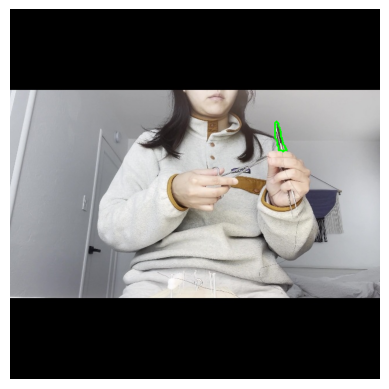

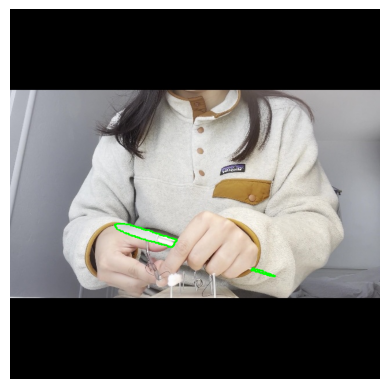

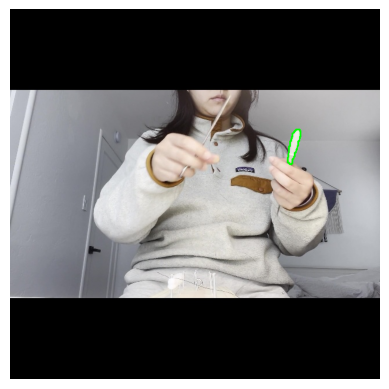

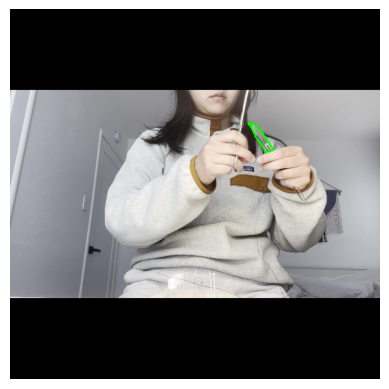

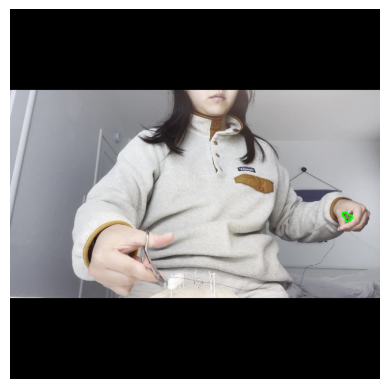

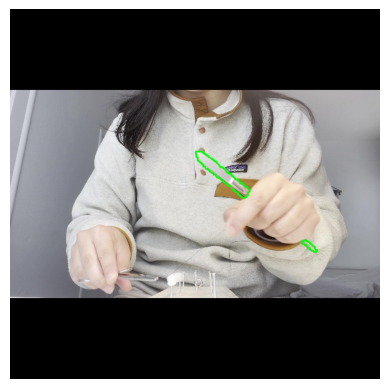

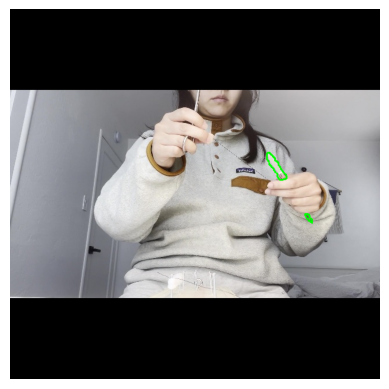

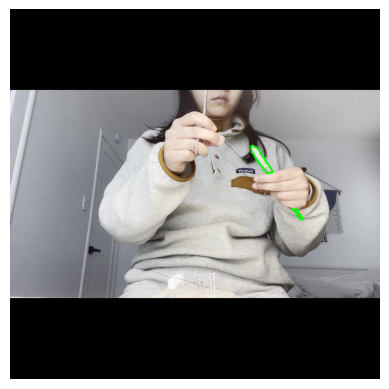

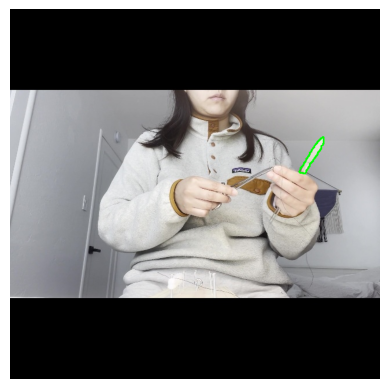

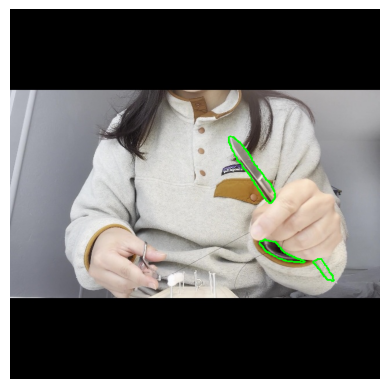

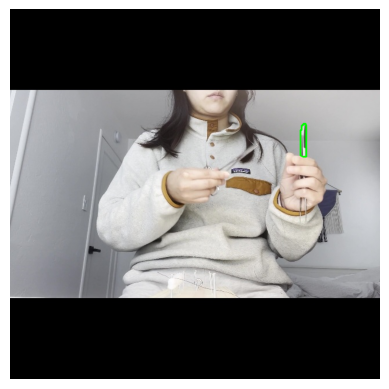

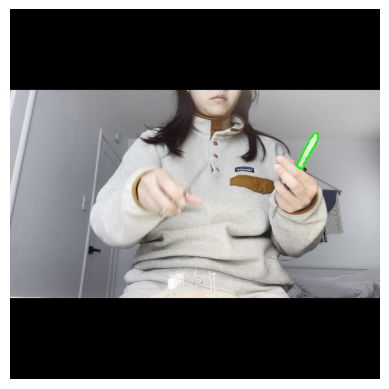

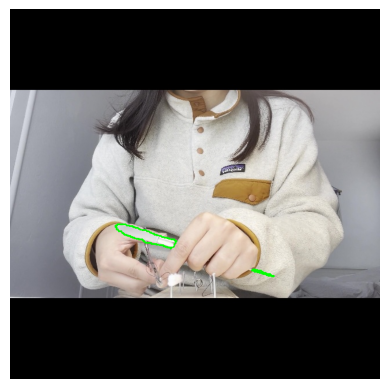

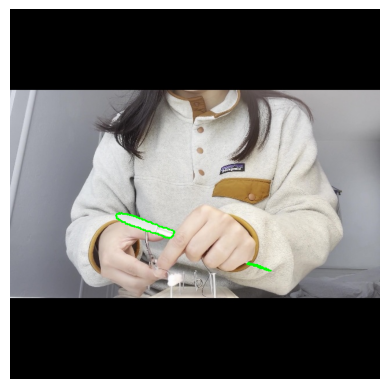

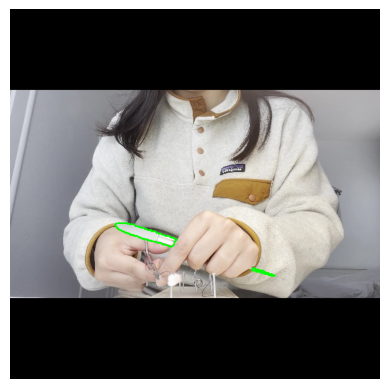

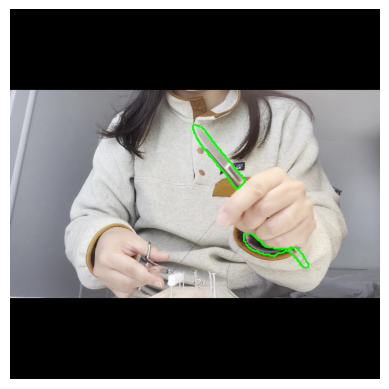

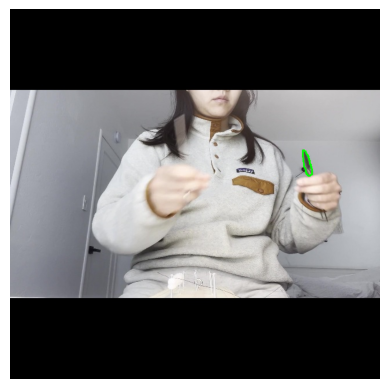

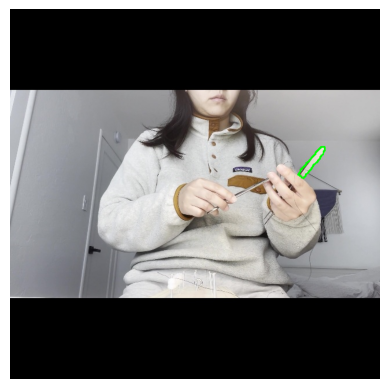

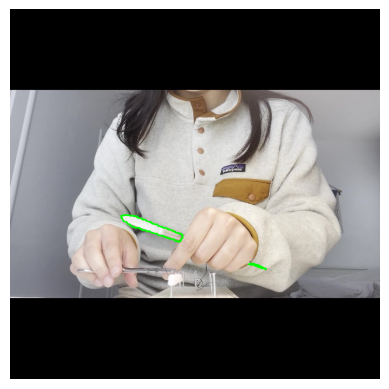

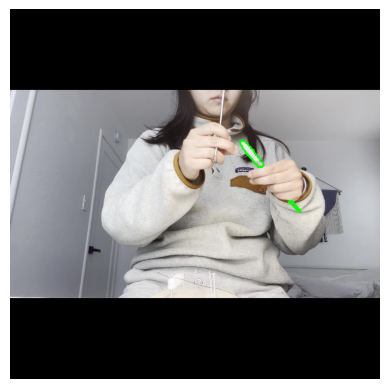

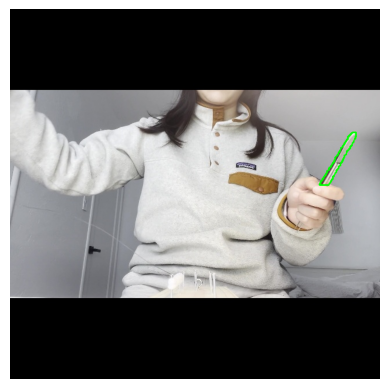

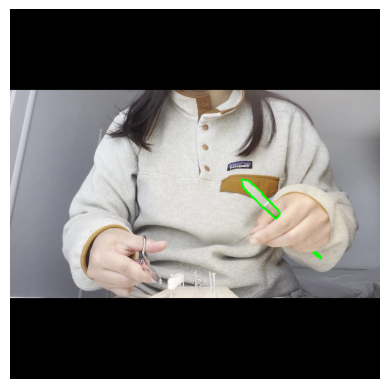

KeyboardInterrupt: 

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def draw_polygon(image, points, color=(0, 255, 0)):
    points = np.array(points, np.int32).reshape((-1, 1, 2))
    cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)

def process_folder(image_folder, label_folder):
    for image_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, image_file)
        lbl_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + '.txt')

        img = cv2.imread(img_path)
        if img is None:
            print(f"Image not found or unreadable: {img_path}")
            continue

        h, w, _ = img.shape
        if os.path.exists(lbl_path):
            with open(lbl_path, "r") as f:
              count = 0
                for line in f:
                    parts = line.strip().split()
                    coords = [float(x) for x in parts[1:]]
                    coords = [(int(x * w), int(y * h)) for x, y in zip(coords[0::2], coords[1::2])]
                    draw_polygon(img, coords)
                    count += 1
                    if count == 5:
                      break
        else:
            print(f"Label file not found: {lbl_path}")

        # Convert BGR to RGB and display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

# Replace with actual folder paths
image_folder = "/content/dataset_2/images/train"
label_folder = "/content/dataset_2/labels/train"

process_folder(image_folder, label_folder)


In [ ]:
# merge the two datasets


 ## Fine tune script

In [ ]:
from ultralytics import YOLO
from torch.cuda.amp import autocast

model = YOLO('yolov8x-seg.pt')

for k, v in model.named_parameters():
    print(k)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 137M/137M [00:03<00:00, 47.1MB/s]


model.model.0.conv.weight
model.model.0.bn.weight
model.model.0.bn.bias
model.model.1.conv.weight
model.model.1.bn.weight
model.model.1.bn.bias
model.model.2.cv1.conv.weight
model.model.2.cv1.bn.weight
model.model.2.cv1.bn.bias
model.model.2.cv2.conv.weight
model.model.2.cv2.bn.weight
model.model.2.cv2.bn.bias
model.model.2.m.0.cv1.conv.weight
model.model.2.m.0.cv1.bn.weight
model.model.2.m.0.cv1.bn.bias
model.model.2.m.0.cv2.conv.weight
model.model.2.m.0.cv2.bn.weight
model.model.2.m.0.cv2.bn.bias
model.model.2.m.1.cv1.conv.weight
model.model.2.m.1.cv1.bn.weight
model.model.2.m.1.cv1.bn.bias
model.model.2.m.1.cv2.conv.weight
model.model.2.m.1.cv2.bn.weight
model.model.2.m.1.cv2.bn.bias
model.model.2.m.2.cv1.conv.weight
model.model.2.m.2.cv1.bn.weight
model.model.2.m.2.cv1.bn.bias
model.model.2.m.2.cv2.conv.weight
model.model.2.m.2.cv2.bn.weight
model.model.2.m.2.cv2.bn.bias
model.model.3.conv.weight
model.model.3.bn.weight
model.model.3.bn.bias
model.model.4.cv1.conv.weight
model.mode

In [ ]:
 # Options: 'yolov8n-seg.pt', 'yolov8s-seg.pt', etc.



# Train the model
model.train(
    data='/content/dataset.yaml',       # Path to dataset configuration file
    epochs=5,                 # Number of epochs
    imgsz=640,                 # Image size for training
    batch=4,                  # Batch size
    device=0,                  # GPU device (set to 'cpu' for CPU training)
    project='segmentation',    # Project name for saving results
    name='yolov8-finetune',    # Name of the run
    workers=2,
    augment= False,
    freeze = 20 # Number of data loader workers

)

# Evaluate the model
#metrics = model.val()




Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/content/dataset.yaml, epochs=5, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=segmentation, name=yolov8-finetune2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=20, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 40.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 160MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/labels/train... 375 images, 25 backgrounds, 0 corrupt: 100%|██████████| 375/375 [00:00<00:00, 1493.61it/s]

train: New cache created: /content/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/labels/val... 89 images, 3 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<00:00, 604.74it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to segmentation/yolov8-finetune2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to segmentation/yolov8-finetune2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       2.2G      1.581      2.896      2.208      1.459          4        640: 100%|██████████| 94/94 [00:24<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.28it/s]

                   all         89        154       0.03      0.773     0.0273     0.0147     0.0245      0.468      0.017    0.00579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         2G       1.55       2.73      1.435      1.439         12        640: 100%|██████████| 94/94 [00:21<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]

                   all         89        154      0.838       0.76       0.81       0.41      0.574      0.513      0.453      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       1.9G      1.644      2.672      1.326       1.47          2        640: 100%|██████████| 94/94 [00:22<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

                   all         89        154      0.879      0.798      0.853      0.456      0.726      0.617      0.582      0.187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.96G      1.553      2.505      1.197      1.409          6        640: 100%|██████████| 94/94 [00:22<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.03it/s]

                   all         89        154      0.906      0.805      0.866      0.498      0.744      0.591      0.595      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.01G      1.484      2.405      1.153      1.383          8        640: 100%|██████████| 94/94 [00:21<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all         89        154      0.872      0.831      0.871       0.49      0.761      0.597      0.571      0.216



5 epochs completed in 0.042 hours.
Optimizer stripped from segmentation/yolov8-finetune2/weights/last.pt, 143.9MB
Optimizer stripped from segmentation/yolov8-finetune2/weights/best.pt, 143.9MB

Validating segmentation/yolov8-finetune2/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-seg summary (fused): 295 layers, 71,721,619 parameters, 0 gradients, 343.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


                   all         89        154        0.9      0.805      0.866      0.497      0.747      0.591      0.591      0.237
Speed: 0.5ms preprocess, 33.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to segmentation/yolov8-finetune2


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c3ce81163b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [ ]:
# unload gpu ram
import torch
torch.cuda.empty_cache()

In [ ]:
from ultralytics import YOLO

model = YOLO('path_to_trained_model.pt')  # Load trained model
results = model.predict(source="path_to_test_images", save=True, save_txt=True, save_conf=True)


#Ale

In [ ]:
mask = masks[0].astype(np.uint8)
mask[mask == 1] = 255
box = boxes[0]

template_img = cv2.imread('/content/drive/MyDrive/AI surgical training/Template/Template_4_cropped.jpg', cv2.IMREAD_GRAYSCALE)
_, template_binary = cv2.threshold(template_img, 127, 255, cv2.THRESH_BINARY)
template_pixel_map = (template_binary).astype(np.uint8)

contours, _ = cv2.findContours(template_pixel_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

diag_mask = np.linalg.norm(box[:2] - box[2:])
diag_template = np.linalg.norm(np.array((x, y)) - np.array((x + w, y + h)))

scale_factor = diag_mask / diag_template

new_width = int(template_pixel_map.shape[1] * scale_factor)
new_height = int(template_pixel_map.shape[0] * scale_factor)
resized_template = cv2.resize(template_pixel_map, (new_width, new_height), interpolation=cv2.INTER_AREA)

result = cv2.matchTemplate(mask, resized_template, cv2.TM_CCOEFF_NORMED)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

(startX, startY) = maxLoc
endX = startX + resized_template.shape[1]
endY = startY + resized_template.shape[0]

cv2.rectangle(mask, (startX, startY), (endX, endY), 255, 3)

template_mask = resized_template.astype(bool)
mask[startY:endY, startX:endX][template_mask] = 255
print(mask.dtype)
print(mask.shape)
print(np.unique(mask))
print(np.count_nonzero(mask))
img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
plt.imshow(img)
plt.show()

In [ ]:

box = boxes[0]
# Calculate the squared differences and sum them directly
distance = np.linalg.norm(box[:2] - box[2:])

print(distance)

In [ ]:
template_img = cv2.imread('/content/template1.jpg', cv2.IMREAD_GRAYSCALE)

# Convert the template to binary and then to a pixel map (0 and 1)
_, template_binary = cv2.threshold(template_img, 127, 255, cv2.THRESH_BINARY)
template_pixel_map = (template_binary // 255).astype(np.uint8)

print(np.unique(template_pixel_map))
print(np.count_nonzero(template_pixel_map))
plt.imshow(template_pixel_map, cmap='gray')
plt.show()

In [ ]:
def get_bounding_box(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:

        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return (x, y, w, h)
    else:
        return None

#bounding boxes for each image
bbox1 = get_bounding_box(mask)
print(bbox1)
bbox2 = get_bounding_box(template_pixel_map)
print(bbox2)

if bbox1 and bbox2:
    _, _, w1, h1 = bbox1
    _, _, w2, h2 = bbox2

    #scaling factors based on width and height ratios
    scale_width = w1 / w2
    scale_height = h1 / h2

    scale_factor = (scale_width + scale_height) / 2.0

    #resizing
    new_width = int(template_pixel_map.shape[1] * scale_factor)
    new_height = int(template_pixel_map.shape[0] * scale_factor)
    resized_image2 = cv2.resize(template_pixel_map, (new_width, new_height), interpolation=cv2.INTER_AREA)

print(np.count_nonzero(resized_image2))
plt.imshow(resized_image2, cmap='gray')
plt.show()

In [ ]:
result = cv2.matchTemplate(mask, resized_image2, cv2.TM_CCOEFF_NORMED)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

# determine the starting and ending (x, y)-coordinates of the
# bounding box
(startX, startY) = maxLoc
endX = startX + resized_image2.shape[1]
endY = startY + resized_image2.shape[0]

# draw the bounding box on the image
cv2.rectangle(mask, (startX, startY), (endX, endY), 1, 3)

template_mask = resized_image2.astype(bool)
mask[startY:endY, startX:endX][template_mask] = 1
# show the output image
print(np.unique(mask))
print(f'Score massimo per il template matching {maxVal}')

plt.imshow(mask, cmap='gray')
plt.show()

# Cotracker 3

In [ ]:
!git clone https://github.com/facebookresearch/co-tracker
%cd co-tracker
!pip install -e .
!pip install opencv-python matplotlib moviepy flow_vis
!mkdir checkpoints
%cd checkpoints
!wget https://huggingface.co/facebook/cotracker3/resolve/main/scaled_online.pth

Cloning into 'co-tracker'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 421 (delta 184), reused 177 (delta 124), pack-reused 138 (from 1)
Receiving objects: 100% (421/421), 74.98 MiB | 35.96 MiB/s, done.
Resolving deltas: 100% (213/213), done.
/content/co-tracker
Obtaining file:///content/co-tracker
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cotracker
/content/co-tracker/checkpoints
--2024-11-26 11:14:45--  https://huggingface.co/facebook/cotracker3/resolve/main/scaled_online.pth
Resolving huggingface.co (huggingface.co)... 3.165.160.59, 3.165.160.61, 3.165.160.11, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/19/7a/197ad7e3e0455746500ab7ba04db277758846b3e1f222c3a3c6e8d6531ad85a6/205d34789f19699d64b22cf93f9b697f15f28d40252

In [ ]:
%cd ..
import os
import torch
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from cotracker.predictor import CoTrackerOnlinePredictor
video_path = "/content/drive/MyDrive/Humanitas/surgical_training/Sam/prova2.mp4"

/


In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import os
import torch
import imageio.v3 as iio
import numpy as np

from cotracker.utils.visualizer import Visualizer
from cotracker.predictor import CoTrackerOnlinePredictor


DEFAULT_DEVICE = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Using the existing video_path variable:
video_path = "/content/drive/MyDrive/Humanitas/surgical_training/Sam/prova2.mp4"
# You can also define checkpoint, grid_size, and grid_query_frame here if needed.
checkpoint = "/content/co-tracker/checkpoints/scaled_online.pth"  # Or the path to your checkpoint file
grid_size = 10
grid_query_frame = 0


if not os.path.isfile(video_path):
    raise ValueError("Video file does not exist")

if checkpoint is not None:
    model = CoTrackerOnlinePredictor(checkpoint=checkpoint)
else:
    model = torch.hub.load("facebookresearch/co-tracker", "cotracker3_online")
model = model.to(DEFAULT_DEVICE)

window_frames = []

def _process_step(window_frames, is_first_step, grid_size, grid_query_frame):
    video_chunk = (
        torch.tensor(
            np.stack(window_frames[-model.step * 2 :]), device=DEFAULT_DEVICE
        )
        .float()
        .permute(0, 3, 1, 2)[None]
    )  # (1, T, 3, H, W)
    return model(
        video_chunk,
        is_first_step=is_first_step,
        grid_size=grid_size,
        grid_query_frame=grid_query_frame,
    )

# Iterating over video frames, processing one window at a time:
is_first_step = True
for i, frame in enumerate(
    iio.imiter(
        video_path, # Using the defined video_path variable
        plugin="FFMPEG",
    )
):
    if i % model.step == 0 and i != 0:
        pred_tracks, pred_visibility = _process_step(
            window_frames,
            is_first_step,
            grid_size=grid_size, # Using the defined grid_size variable
            grid_query_frame=grid_query_frame, # Using the defined grid_query_frame variable
        )
        is_first_step = False
    window_frames.append(frame)
# Processing the final video frames in case video length is not a multiple of model.step
pred_tracks, pred_visibility = _process_step(
    window_frames[-(i % model.step) - model.step - 1 :],
    is_first_step,
    grid_size=grid_size, # Using the defined grid_size variable
    grid_query_frame=grid_query_frame, # Using the defined grid_query_frame variable
)

print("Tracks are computed")

# save a video with predicted tracks
seq_name = video_path.split("/")[-1] # Using the defined video_path variable
video = torch.tensor(np.stack(window_frames), device=DEFAULT_DEVICE).permute(0, 3, 1, 2)

Tracks are computed


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [ ]:

video = torch.tensor(np.stack(window_frames), device=DEFAULT_DEVICE).permute(0, 3, 1, 2)[None]
vis = Visualizer(save_dir="./saved_videos", pad_value=120, linewidth=3)
vis.visualize(
        video, pred_tracks, pred_visibility)

Video saved to ./saved_videos/video.mp4


tensor([[[[[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]],

          [[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]],

          [[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]]],


         [[[255, 255, 255,  ..., 255, 255, 255],
           [2

In [ ]:
vis.visualize(
        video, pred_tracks, pred_visibility)

In [ ]:
video = torch.tensor(frames).permute(0, 3, 1, 2)[None].float().to(device)  # B T C H W


In [ ]:
cotracker(video_chunk=video, is_first_step=True, grid_size=grid_size)